In [256]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
# import seaborn as sns
import math
# import datetime
# import pickle
import joblib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [257]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [258]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284
std,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508
50%,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008
75%,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


Imputing value in the preprocessed dataset

In [259]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [260]:
x_pre = imputer.transform(dfpre)

In [261]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [262]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [263]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [264]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [265]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [266]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [267]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [268]:
# # SOG threshold according to Abebe20 and Yan21

# df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by applying higher threshold

# df = df[df['SOG'] > 12 ]

# Improve model performance ? , reduce skew of the dataset by removing outliers mu pm 3sigma 

df = df[df['SOG'] > 8 ]

In [269]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

# Summer
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")
print("#########################################")
# Winter
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

# df_test_set = dfwinter
# df_test_set = dfsummer  
# df_test_set= test_set



length of May dataset 43
length of June dataset 75
length of July dataset 71
length of August dataset 75
length of Sept dataset 81
length of Oct dataset 83
#########################################
length of Nov dataset 73
length of Dec dataset 77
length of Jan dataset 95
length of Feb dataset 80
length of March dataset 79
length of April dataset 82


In [270]:
dfsummer.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,428.000000,428.000000,428.000000,428.000000,414.000000,403.000000,403.000000,403.000000,403.000000,413.000000,...,428.000000,428.000000,428.000000,403.000000,403.000000,403.000000,428.000000,428.000000,428.000000,428.000000
mean,4413.238318,13.531942,55.225007,286.192811,1.227799,1.466923,4.074916,3.336763,3.660457,286.660269,...,189.331250,91.328751,87.468853,86.966674,87.767188,88.615502,0.098252,6.576387,196.334757,151.903437
std,1734.580687,0.724761,0.097393,5.910377,0.029126,1.125451,1.112759,0.974981,0.956831,5.093402,...,89.648321,58.062009,60.833144,59.987180,55.042751,60.522579,0.074064,3.092907,91.278350,99.523421
min,96.000000,12.245846,55.059198,267.603760,1.181071,0.107192,1.967748,1.679970,1.967748,273.841797,...,87.138163,0.534502,1.664546,0.761416,0.070775,0.228984,0.001416,0.345946,4.329156,0.587267
25%,3488.500000,12.902434,55.144197,283.322083,1.204246,0.658677,3.218803,2.560097,2.899067,283.170776,...,99.206973,36.052912,25.830065,28.679384,41.169402,27.528237,0.044432,4.160269,136.146251,77.906768
50%,4584.500000,13.572807,55.209330,287.480835,1.223315,1.144267,3.994395,3.259926,3.492161,288.164551,...,126.576871,92.422766,82.219046,83.691580,85.113259,78.754356,0.076747,6.395487,198.357238,124.894501
75%,5740.250000,14.085116,55.269062,290.622070,1.242806,1.900809,4.829518,3.864906,4.257621,290.459228,...,278.496664,146.132217,147.237921,145.520767,135.558305,150.516276,0.134743,8.446044,277.039876,223.686770
max,7499.000000,14.669474,55.609090,296.022461,1.324176,5.946585,7.473089,6.162514,6.425161,294.751709,...,302.929975,179.540146,179.818805,179.407150,179.491314,179.830612,0.497666,15.439603,358.517954,359.450078


In [271]:
dfwinter.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,486.000000,486.000000,486.000000,486.000000,469.000000,458.000000,458.000000,458.000000,458.000000,467.000000,...,486.000000,486.000000,486.000000,458.000000,458.000000,458.000000,486.000000,486.000000,486.000000,486.000000
mean,3442.672840,13.466969,55.232294,279.094714,1.260359,1.444289,4.167805,3.269401,3.706690,279.961027,...,188.879557,90.381800,97.812018,86.706775,90.712392,88.316114,0.101138,6.598807,205.146261,152.572902
std,2663.554609,0.752951,0.097789,5.014006,0.028414,0.929811,0.942518,0.858922,0.799457,4.456245,...,90.169293,54.504721,54.217488,52.216875,52.732837,53.929150,0.065053,2.832183,95.549274,99.475317
min,8.000000,12.246671,55.091068,267.095032,1.194377,0.106847,1.734445,1.570107,1.734445,273.434815,...,91.468757,0.000973,0.248414,0.349338,1.462440,0.395038,0.003199,0.427826,1.009372,1.120417
25%,1223.500000,12.872137,55.142164,275.930717,1.244266,0.699814,3.472840,2.587348,3.107469,276.982422,...,99.868340,40.280577,46.622313,41.294534,47.613220,41.392347,0.056219,4.370227,149.018366,77.156028
50%,2428.000000,13.399024,55.225596,278.153320,1.264185,1.215216,4.136292,3.273048,3.620674,278.455566,...,123.948513,94.702786,101.234961,84.027622,88.756664,84.271611,0.090074,6.486007,211.994310,125.525598
75%,6674.500000,14.106287,55.276023,280.608582,1.278132,1.940051,4.860943,3.864906,4.277860,281.882324,...,280.927227,140.056832,145.585217,132.405263,136.146717,134.623622,0.132989,8.619949,280.877386,234.297045
max,7976.000000,14.619396,55.450027,292.722778,1.336689,4.866058,6.659266,5.491858,5.686860,292.665283,...,305.693183,179.849755,179.952696,179.333213,179.813891,179.897758,0.525174,14.137048,359.462360,359.264290


In [272]:
dfyear.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,914.000000,914.000000,914.000000,914.000000,883.000000,861.000000,861.000000,861.000000,861.000000,880.000000,...,914.000000,914.000000,914.000000,861.000000,861.000000,861.000000,914.000000,914.000000,914.000000,914.000000
mean,3897.160832,13.497394,55.228882,282.418549,1.245093,1.454883,4.124327,3.300931,3.685050,283.105103,...,189.091072,90.825230,92.968611,86.828423,89.333858,88.456245,0.099787,6.588308,201.020086,152.259411
std,2326.090934,0.740192,0.097618,6.500095,0.033014,1.025488,1.026164,0.915156,0.876424,5.820473,...,89.876771,56.169493,57.610396,55.955269,53.814976,57.076607,0.069395,2.955519,93.626045,99.443900
min,8.000000,12.245846,55.059198,267.095032,1.181071,0.106847,1.734445,1.570107,1.734445,273.434815,...,87.138163,0.000973,0.248414,0.349338,0.070775,0.228984,0.001416,0.345946,1.009372,0.587267
25%,1858.250000,12.883421,55.143390,277.033936,1.217863,0.674789,3.349772,2.562050,3.015750,277.912964,...,99.577874,37.915590,37.275418,35.577385,44.754257,35.772643,0.049891,4.276052,141.752669,77.189636
50%,3860.000000,13.537094,55.216499,281.451538,1.245638,1.186821,4.076095,3.265811,3.581203,282.434631,...,125.121937,94.138462,96.190659,83.927297,86.592713,82.811436,0.082986,6.419910,205.782268,125.294558
75%,5854.750000,14.092155,55.274254,288.664612,1.271136,1.933236,4.839375,3.864906,4.258592,288.801849,...,279.587442,142.819225,146.472367,140.074949,135.979478,142.396843,0.133803,8.522994,278.803337,228.131645
max,7976.000000,14.669474,55.609090,296.022461,1.336689,5.946585,7.473089,6.162514,6.425161,294.751709,...,305.693183,179.849755,179.952696,179.407150,179.813891,179.897758,0.525174,15.439603,359.462360,359.450078


Exporting File

In [273]:
# df.to_csv('June_update.csv')

Measure performance in Season, data pre processing by dropping unnecessary feature and renaming


In [274]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)


In [275]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [276]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# # For summer 
# dfsummer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

df_summer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# For Winter
# dfwinter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]
df_winter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]


# For the whole year
# dfyear = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

df_year = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]

In [277]:
dfyear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 2949 to 712
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     914 non-null    float64
 1   waveheight           861 non-null    float64
 2   swellperiod          861 non-null    float64
 3   windwaveperiod       861 non-null    float64
 4   waveperiod           861 non-null    float64
 5   surftemp             880 non-null    float64
 6   windwaveswellheight  861 non-null    float64
 7   swellheight          861 non-null    float64
 8   windwaveheight       861 non-null    float64
 9   draught              914 non-null    float64
 10  sog                  914 non-null    float64
 11  cog                  914 non-null    float64
 12  heading              914 non-null    float64
 13  truewinddir          914 non-null    float64
 14  truecurrentdir       914 non-null    float64
 15  trueswelldir         861 non-null    

Imputing to complete the data

In [278]:
import numpy as np
from sklearn.impute import KNNImputer

imputer_s = KNNImputer(n_neighbors=50)
imputer_s.fit(df_summer)

# Transform imputed summer dataset

xsummer = imputer_s.transform(df_summer)

# Column heading set same

df_summer_tr = pd.DataFrame(xsummer, columns=df_summer.columns, index=df_summer.index)

In [279]:
# Impute for winter data 

imputer_w = KNNImputer(n_neighbors=50)
imputer_w.fit(df_winter)

# Transform imputed winter dataset

xwinter = imputer_w.transform(df_winter)

#Column heading set same 

df_winter_tr = pd.DataFrame(xwinter, columns=df_winter.columns, index=df_winter.index)


In [280]:
# Impute for yearly data 

imputer_yr = KNNImputer(n_neighbors=50)
imputer_yr.fit(df_year)

# Transform imputed year dataset 

xyear = imputer_yr.transform(df_year)

#Column heading set same

df_year_tr = pd.DataFrame(xyear, columns=df_year.columns, index=df_year.index)

In [281]:
df_year_tr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,282.418549,3.682237,283.080962,0.763092,5.223797,17.530370,194.184104,189.091072,6.588308,0.099787,90.825230,92.968611,88.200200
std,6.500095,0.852515,5.721425,0.508798,0.183835,2.148382,88.605155,89.876771,2.955519,0.069395,56.169493,57.610396,56.441178
min,267.095032,1.734445,273.434815,0.070604,4.742534,8.034808,85.957578,87.138163,0.345946,0.001416,0.000973,0.248414,0.228984
25%,277.033936,3.050550,277.970215,0.383893,5.109162,16.938559,101.398393,99.577874,4.276052,0.049891,37.915590,37.275418,36.471017
50%,281.451538,3.580226,282.434631,0.646323,5.287618,18.126637,149.502262,125.121937,6.419910,0.082986,94.138462,96.190659,82.653903
75%,288.664612,4.227607,288.702148,0.980802,5.377070,18.754099,282.568226,279.587442,8.522994,0.133803,142.819225,146.472367,140.885305
max,296.022461,6.425161,294.751709,3.073458,5.658328,20.935741,306.718481,305.693183,15.439603,0.525174,179.849755,179.952696,179.897758


In [282]:
# # Impute for different dataframe 

# imputer.fit(dfsummer)
# imputer.fit(dfwinter)
# imputer.fit(dfyear)

In [283]:
# xsummer = imputer.transform(dfsummer)
# xwinter = imputer.transform(dfwinter)
# xyear = imputer.transform(dfyear)

In [284]:
# df_summer_tr = pd.DataFrame(xsummer, columns=dfsummer.columns, index=dfsummer.index)
# df_winter_tr = pd.DataFrame(xwinter, columns=dfwinter.columns, index=dfwinter.index)
# df_year_tr = pd.DataFrame(xyear, columns=dfyear.columns, index=dfyear.index)

In [285]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog'],axis=1)
y_date_yr = df_year_tr.sog

In [286]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 914
Amount of the summer dataset is 428
Amount of the winter dataset is 486


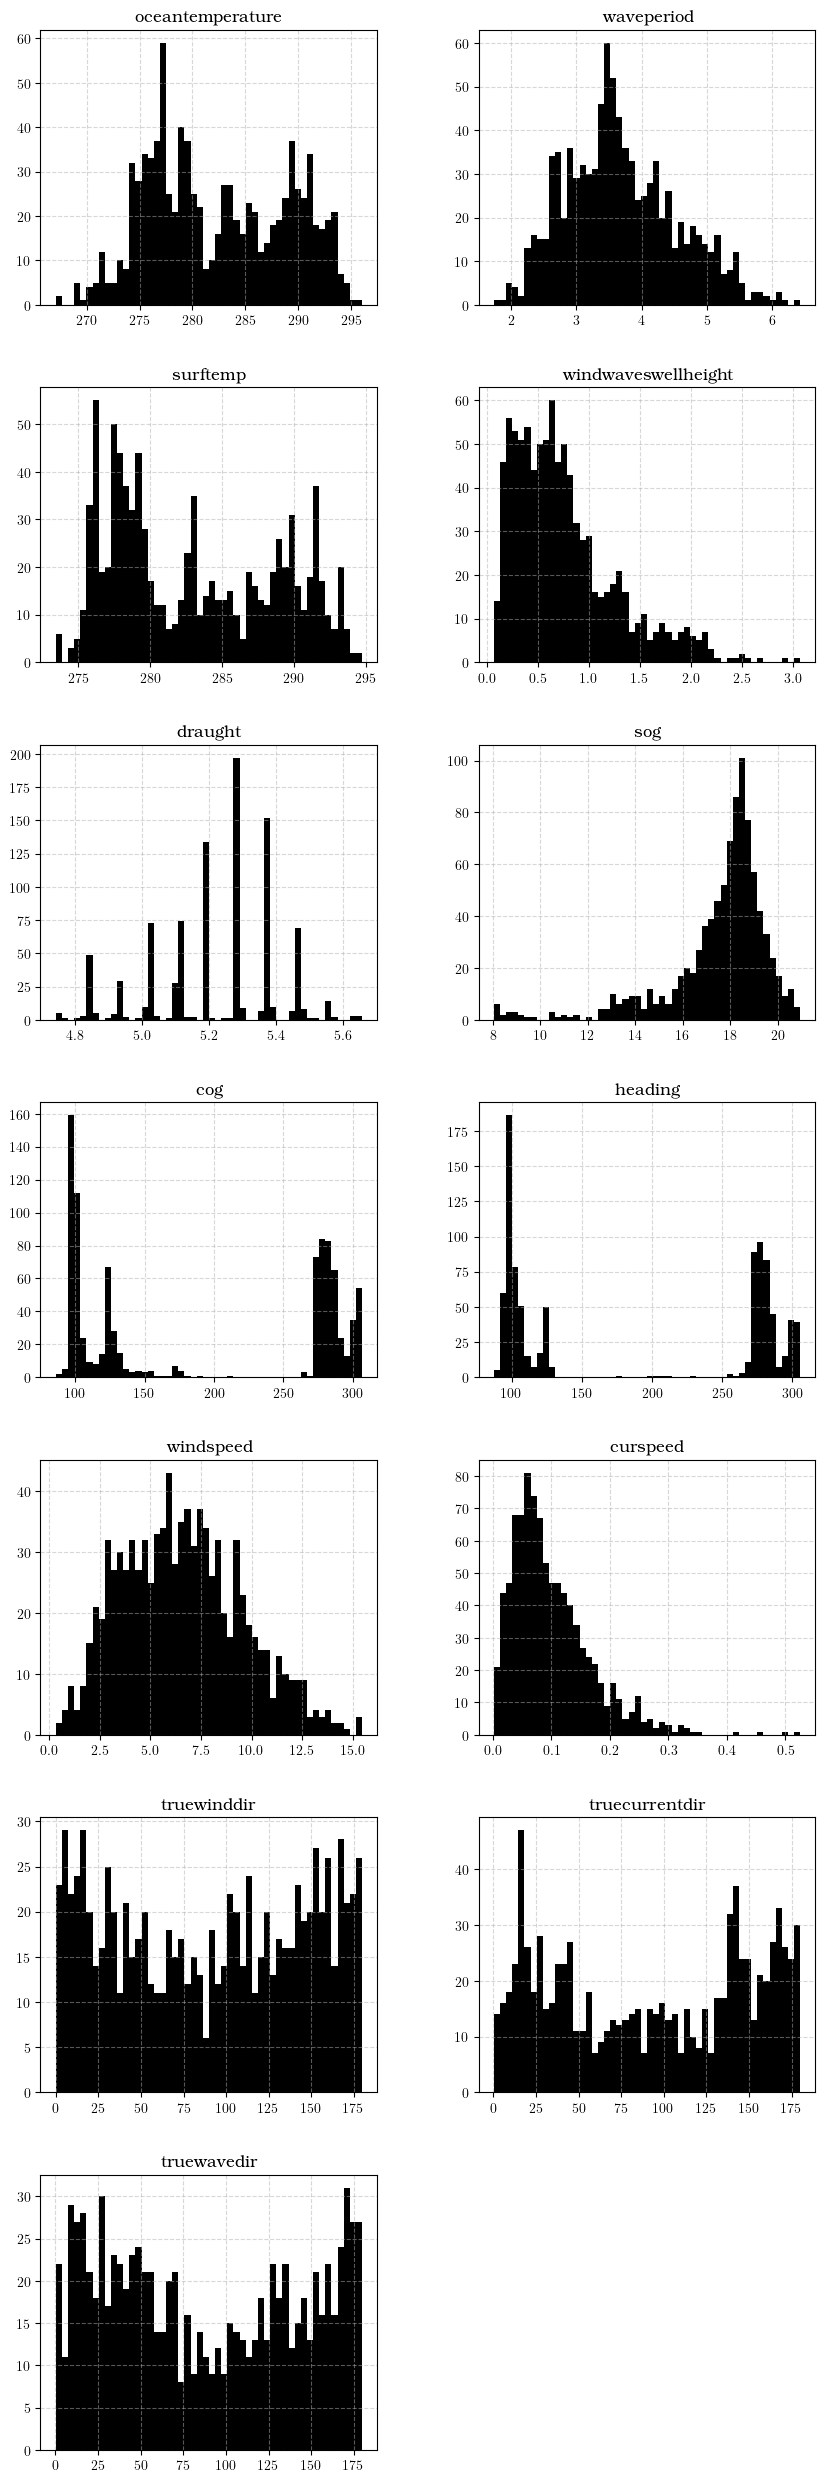

In [287]:
# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [288]:
x_date_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,282.418549,3.682237,283.080962,0.763092,5.223797,194.184104,189.091072,6.588308,0.099787,90.825230,92.968611,88.200200
std,6.500095,0.852515,5.721425,0.508798,0.183835,88.605155,89.876771,2.955519,0.069395,56.169493,57.610396,56.441178
min,267.095032,1.734445,273.434815,0.070604,4.742534,85.957578,87.138163,0.345946,0.001416,0.000973,0.248414,0.228984
25%,277.033936,3.050550,277.970215,0.383893,5.109162,101.398393,99.577874,4.276052,0.049891,37.915590,37.275418,36.471017
50%,281.451538,3.580226,282.434631,0.646323,5.287618,149.502262,125.121937,6.419910,0.082986,94.138462,96.190659,82.653903
75%,288.664612,4.227607,288.702148,0.980802,5.377070,282.568226,279.587442,8.522994,0.133803,142.819225,146.472367,140.885305
max,296.022461,6.425161,294.751709,3.073458,5.658328,306.718481,305.693183,15.439603,0.525174,179.849755,179.952696,179.897758


In [289]:
stats_DSyear = x_date_yr.describe().transpose()
print(stats_DSyear.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
914.00 & 282.42 &  6.50 & 267.10 & 277.03 & 281.45 & 288.66 & 296.02 \\
914.00 &   3.68 &  0.85 &   1.73 &   3.05 &   3.58 &   4.23 &   6.43 \\
914.00 & 283.08 &  5.72 & 273.43 & 277.97 & 282.43 & 288.70 & 294.75 \\
914.00 &   0.76 &  0.51 &   0.07 &   0.38 &   0.65 &   0.98 &   3.07 \\
914.00 &   5.22 &  0.18 &   4.74 &   5.11 &   5.29 &   5.38 &   5.66 \\
914.00 & 194.18 & 88.61 &  85.96 & 101.40 & 149.50 & 282.57 & 306.72 \\
914.00 & 189.09 & 89.88 &  87.14 &  99.58 & 125.12 & 279.59 & 305.69 \\
914.00 &   6.59 &  2.96 &   0.35 &   4.28 &   6.42 &   8.52 &  15.44 \\
914.00 &   0.10 &  0.07 &   0.00 &   0.05 &   0.08 &   0.13 &   0.53 \\
914.00 &  90.83 & 56.17 &   0.00 &  37.92 &  94.14 & 142.82 & 179.85 \\
914.00 &  92.97 & 57.61 &   0.25 &  37.28 &  96.19 & 146.47 & 179.95 \\
914.00 &  88.20 & 56.44 &   0.23 &  36.47 &  82.65 & 140.89 & 179.90 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_21272\243031061.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSyear.to_latex(index=False,


In [290]:
y_date_yr.describe()

count    914.000000
mean      17.530370
std        2.148382
min        8.034808
25%       16.938559
50%       18.126637
75%       18.754099
max       20.935741
Name: sog, dtype: float64

In [291]:
x_date_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,286.192811,3.654333,286.667389,0.769020,5.286757,194.664533,189.331250,6.576387,0.098252,91.328751,87.468853,88.190230
std,5.910377,0.929812,5.008613,0.559502,0.163145,89.030063,89.648321,3.092907,0.074064,58.062009,60.833144,59.852766
min,267.603760,1.967748,273.841797,0.070604,4.742534,92.881843,87.138163,0.345946,0.001416,0.534502,1.664546,0.228984
25%,283.322083,2.948904,283.231201,0.366505,5.199722,100.343270,99.206973,4.160269,0.044432,36.052912,25.830065,27.926122
50%,287.480835,3.492023,288.103271,0.624225,5.290878,165.866272,126.576871,6.395487,0.076747,92.422766,82.219046,78.894625
75%,290.622070,4.192358,290.363281,0.963659,5.380484,281.799961,278.496664,8.446044,0.134743,146.132217,147.237921,146.134677
max,296.022461,6.425161,294.751709,3.073458,5.658328,305.270152,302.929975,15.439603,0.497666,179.540146,179.818805,179.830612


In [292]:
stats_DSsummer = x_date_s.describe().transpose()
print(stats_DSsummer.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
428.00 & 286.19 &  5.91 & 267.60 & 283.32 & 287.48 & 290.62 & 296.02 \\
428.00 &   3.65 &  0.93 &   1.97 &   2.95 &   3.49 &   4.19 &   6.43 \\
428.00 & 286.67 &  5.01 & 273.84 & 283.23 & 288.10 & 290.36 & 294.75 \\
428.00 &   0.77 &  0.56 &   0.07 &   0.37 &   0.62 &   0.96 &   3.07 \\
428.00 &   5.29 &  0.16 &   4.74 &   5.20 &   5.29 &   5.38 &   5.66 \\
428.00 & 194.66 & 89.03 &  92.88 & 100.34 & 165.87 & 281.80 & 305.27 \\
428.00 & 189.33 & 89.65 &  87.14 &  99.21 & 126.58 & 278.50 & 302.93 \\
428.00 &   6.58 &  3.09 &   0.35 &   4.16 &   6.40 &   8.45 &  15.44 \\
428.00 &   0.10 &  0.07 &   0.00 &   0.04 &   0.08 &   0.13 &   0.50 \\
428.00 &  91.33 & 58.06 &   0.53 &  36.05 &  92.42 & 146.13 & 179.54 \\
428.00 &  87.47 & 60.83 &   1.66 &  25.83 &  82.22 & 147.24 & 179.82 \\
428.00 &  88.19 & 59.85 &   0.23 &  27.93 &  78.89 & 146.13 & 179.83 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_21272\2468198302.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSsummer.to_latex(index=False,


In [293]:
y_date_s.describe()

count    428.000000
mean      17.676746
std        2.162112
min        8.162171
25%       16.939840
50%       18.201839
75%       18.991863
max       20.935741
Name: sog, dtype: float64

In [294]:
x_date_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,279.094714,3.707963,279.939318,0.759570,5.168351,193.761009,188.879557,6.598807,0.101138,90.381800,97.812018,88.209011
std,5.014006,0.776741,4.370611,0.459491,0.183321,88.318885,90.169293,2.832183,0.065053,54.504721,54.217488,53.021941
min,267.095032,1.734445,273.434815,0.086519,4.749550,85.957578,91.468757,0.427826,0.003199,0.000973,0.248414,0.395038
25%,275.930717,3.160014,277.091949,0.393096,5.021759,101.747781,99.868340,4.370227,0.056219,40.280577,46.622313,42.689199
50%,278.153320,3.663427,278.521790,0.694169,5.199712,144.751083,123.948513,6.486007,0.090074,94.702786,101.234961,83.738215
75%,280.608582,4.240325,281.525879,0.991051,5.289840,283.254103,280.927227,8.619949,0.132989,140.056832,145.585217,133.832659
max,292.722778,5.686860,292.665283,2.506601,5.654461,306.718481,305.693183,14.137048,0.525174,179.849755,179.952696,179.897758


In [295]:
stats_DSwinter = x_date_w.describe().transpose()
print(stats_DSwinter.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
486.00 & 279.09 &  5.01 & 267.10 & 275.93 & 278.15 & 280.61 & 292.72 \\
486.00 &   3.71 &  0.78 &   1.73 &   3.16 &   3.66 &   4.24 &   5.69 \\
486.00 & 279.94 &  4.37 & 273.43 & 277.09 & 278.52 & 281.53 & 292.67 \\
486.00 &   0.76 &  0.46 &   0.09 &   0.39 &   0.69 &   0.99 &   2.51 \\
486.00 &   5.17 &  0.18 &   4.75 &   5.02 &   5.20 &   5.29 &   5.65 \\
486.00 & 193.76 & 88.32 &  85.96 & 101.75 & 144.75 & 283.25 & 306.72 \\
486.00 & 188.88 & 90.17 &  91.47 &  99.87 & 123.95 & 280.93 & 305.69 \\
486.00 &   6.60 &  2.83 &   0.43 &   4.37 &   6.49 &   8.62 &  14.14 \\
486.00 &   0.10 &  0.07 &   0.00 &   0.06 &   0.09 &   0.13 &   0.53 \\
486.00 &  90.38 & 54.50 &   0.00 &  40.28 &  94.70 & 140.06 & 179.85 \\
486.00 &  97.81 & 54.22 &   0.25 &  46.62 & 101.23 & 145.59 & 179.95 \\
486.00 &  88.21 & 53.02 &   0.40 &  42.69 &  83.74 & 133.83 & 179.90 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_21272\2440674044.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSwinter.to_latex(index=False,


In [296]:
y_date_w.describe()

count    486.000000
mean      17.401464
std        2.130117
min        8.034808
25%       16.922608
50%       18.057275
75%       18.624666
max       20.701952
Name: sog, dtype: float64

In [297]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD    

RFR evaluation

In [298]:
# # Model performance for one year test data

# r2_rfo_yr,expVar_rfo_yr,MAE_rfo_yr,RMSE_rfo_yr,MAD_rfo_yr = evaluate(model_rfr_hpov,x_date_yr,y_date_yr)

In [299]:
# # Model performance for winter test data

# r2_rfo_w,expVar_rfo_w,MAE_rfo_w,RMSE_rfo_w,MAD_rfo_w = evaluate(model_rfr_hpov,x_date_w,y_date_w)

In [300]:
# # Model performance for summer test data

# r2_rfo_s,expVar_rfo_s,MAE_rfo_s,RMSE_rfo_s,MAD_rfo_s = evaluate(model_rfr_hpov,x_date_s,y_date_s)

ETR evaluation

In [301]:
# # Model performance for one year test data

# r2_eto_yr,expVar_eto_yr,MAE_eto_yr,RMSE_eto_yr,MAD_eto_yr = evaluate(model_etr_hpov,x_date_yr,y_date_yr)

In [302]:
# # Model performance for winter test data

# r2_eto_w,expVar_eto_w,MAE_eto_w,RMSE_eto_w,MAD_eto_w = evaluate(model_etr_hpov,x_date_w,y_date_w)

In [303]:
# # Model performance for summer test data

# r2_eto_s,expVar_eto_s,MAE_eto_s,RMSE_eto_s,MAD_eto_s = evaluate(model_etr_hpov,x_date_s,y_date_s)

DT evaluation

In [304]:
# r2_dto_yr,expVar_dto_yr,MAE_dto_yr,RMSE_dto_yr,MAD_dto_yr = evaluate(model_dtr_hpov,x_date_yr,y_date_yr)

In [305]:
# r2_dto_w,expVar_dto_w,MAE_dto_w,RMSE_dto_w,MAD_dto_w = evaluate(model_dtr_hpov,x_date_w,y_date_w)

In [306]:
# r2_dto_s,expVar_dto_s,MAE_dto_s,RMSE_dto_s,MAD_dto_s = evaluate(model_dtr_hpov,x_date_s,y_date_s)

ML evaluation

In [307]:
# r2_mlr_yr,expVar_mlr_yr,MAE_mlr_yr,RMSE_mlr_yr,MAD_mlr_yr = evaluate(model_mlr_ftr,x_date_yr,y_date_yr)

In [308]:
# r2_mlr_w,expVar_mlr_w,MAE_mlr_w,RMSE_mlr_w,MAD_mlr_w = evaluate(model_mlr_ftr,x_date_w,y_date_w)

In [309]:
# r2_mlr_s,expVar_mlr_s,MAE_mlr_s,RMSE_mlr_s,MAD_mlr_s = evaluate(model_mlr_ftr,x_date_s,y_date_s)

In [310]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

Check absolute performance of the model on test data

ETR

In [311]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9260
Explained Variance SOG = 0.9262
MSE SOG = 0.3626 Knots
RMSE SOG = 0.5841 Knots
MAD SOG = 0.2339 Knots
MAPE SOG = 2.1943 %


In [312]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9485
Explained Variance SOG = 0.9485
MSE SOG = 0.3243 Knots
RMSE SOG = 0.4831 Knots
MAD SOG = 0.2121 Knots
MAPE SOG = 1.9738 %


In [313]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9001
Explained Variance SOG = 0.9012
MSE SOG = 0.4085 Knots
RMSE SOG = 0.6825 Knots
MAD SOG = 0.2525 Knots
MAPE SOG = 2.4588 %


RFR

In [314]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9196
Explained Variance SOG = 0.9197
MSE SOG = 0.3478 Knots
RMSE SOG = 0.6090 Knots
MAD SOG = 0.2073 Knots
MAPE SOG = 2.1095 %


In [315]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9533
Explained Variance SOG = 0.9533
MSE SOG = 0.3035 Knots
RMSE SOG = 0.4600 Knots
MAD SOG = 0.2010 Knots
MAPE SOG = 1.8297 %


In [316]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8818
Explained Variance SOG = 0.8824
MSE SOG = 0.3989 Knots
RMSE SOG = 0.7425 Knots
MAD SOG = 0.2172 Knots
MAPE SOG = 2.4315 %


DTR


In [317]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.7954
Explained Variance SOG = 0.7955
MSE SOG = 0.6578 Knots
RMSE SOG = 0.9713 Knots
MAD SOG = 0.4616 Knots
MAPE SOG = 3.9860 %


In [318]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8417
Explained Variance SOG = 0.8417
MSE SOG = 0.5837 Knots
RMSE SOG = 0.8467 Knots
MAD SOG = 0.4068 Knots
MAPE SOG = 3.5286 %


In [319]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.7426
Explained Variance SOG = 0.7436
MSE SOG = 0.7418 Knots
RMSE SOG = 1.0957 Knots
MAD SOG = 0.5239 Knots
MAPE SOG = 4.5054 %


MLR

In [320]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.5022
Explained Variance SOG = 0.5109
MSE SOG = 1.0864 Knots
RMSE SOG = 1.5150 Knots
MAD SOG = 0.8858 Knots
MAPE SOG = 6.6643 %


In [321]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.5442
Explained Variance SOG = 0.5607
MSE SOG = 1.1056 Knots
RMSE SOG = 1.4580 Knots
MAD SOG = 0.9306 Knots
MAPE SOG = 6.6168 %


In [322]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.4585
Explained Variance SOG = 0.4626
MSE SOG = 1.0689 Knots
RMSE SOG = 1.5659 Knots
MAD SOG = 0.8667 Knots
MAPE SOG = 6.7011 %


In [323]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend(fontsize=14)



0.7953743250832019
y = 0.8 * x + 2.8
0.9195628230991869
y = 0.9 * x + 1.4
0.9259887734207554
y = 0.9 * x + 1.6


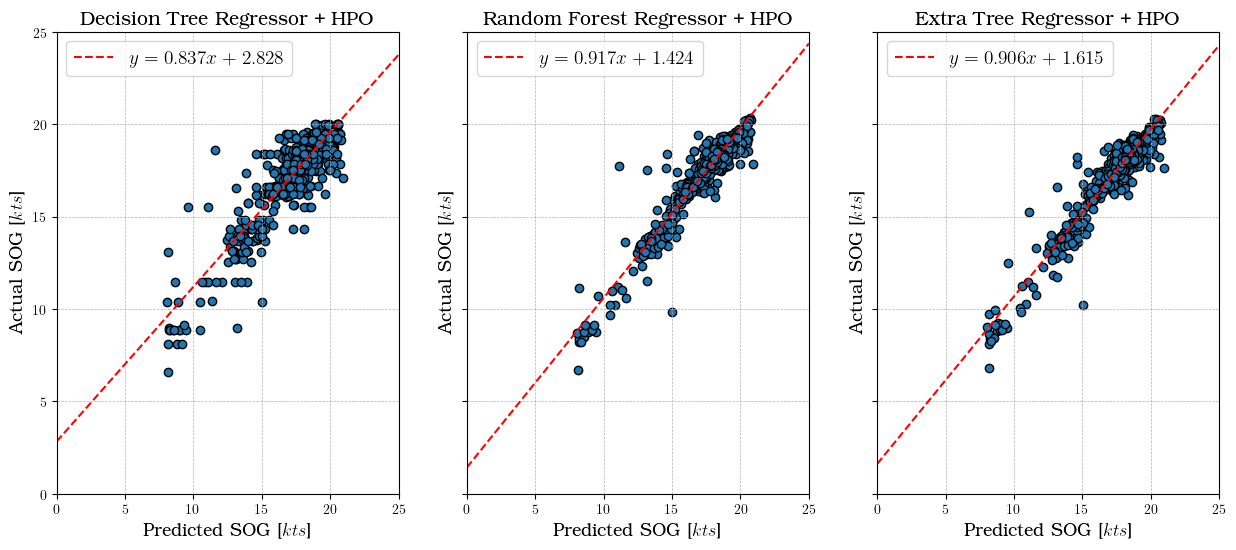

In [324]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[2])
pred_plot(model_etr_hpov,'Extra Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.show()

0.8842866269511369
y = 1.0 * x + 0.7
0.7953743250832019
y = 0.8 * x + 2.8


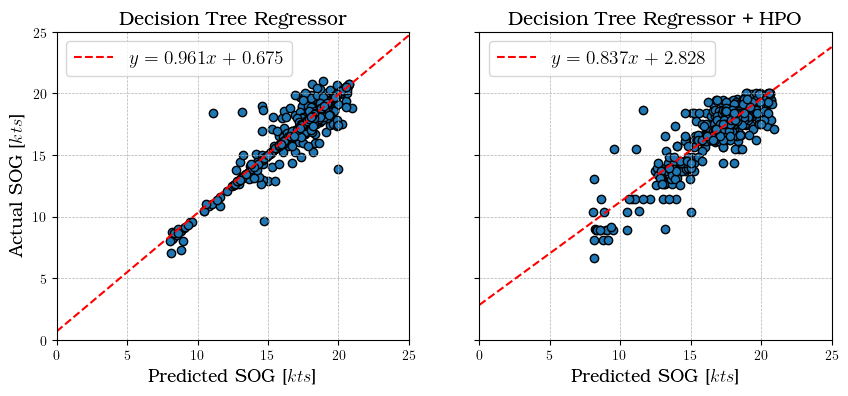

In [325]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9143069246395431
y = 0.9 * x + 1.4
0.9195628230991869
y = 0.9 * x + 1.4


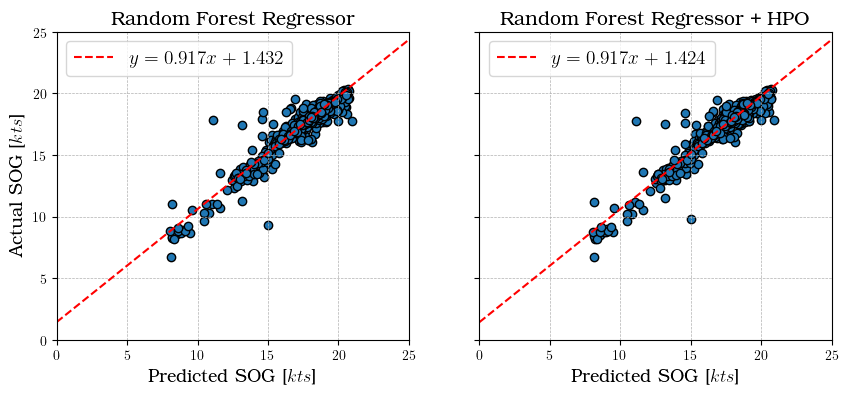

In [326]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9539720153015662
y = 1.0 * x + 0.5
0.9259887734207554
y = 0.9 * x + 1.6


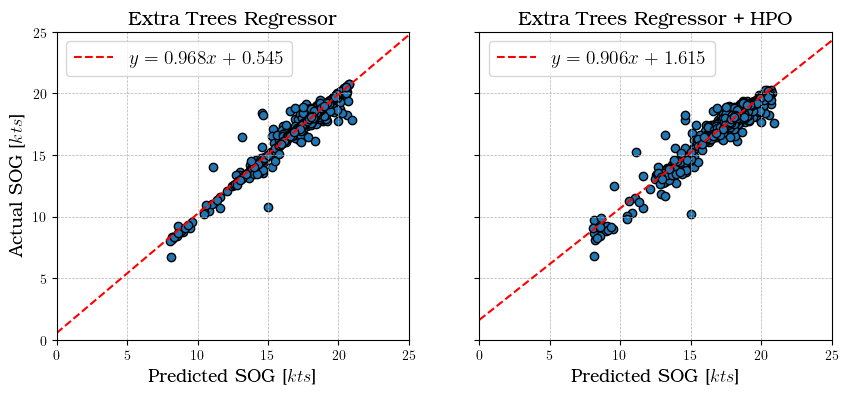

In [327]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

In [328]:
# scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0.2,1.0)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

In [329]:
# scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

Optimization comparison

In [330]:
# scores_opt = [r2_rfo_s,r2_rfo_w,r2_eto_s,r2_eto_w,r2_dto_s,r2_dto_w]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Optimized Model on Test Dataset Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
#                     r'$ETR_{sum}$', r'$ETR_{win}$',
#                     r'$DTR_{sum}$',r'$DTR_{win}$'])
# plt.show()

In [331]:
# rmse_opt = [RMSE_rfo_s,RMSE_rfo_w,RMSE_eto_s,RMSE_eto_w,RMSE_dto_s,RMSE_dto_w]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Optimized Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,2)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
#                     r'$ETR_{sum}$', r'$ETR_{win}$',
#                     r'$DTR_{sum}$',r'$DTR_{win}$'])
# plt.show()

In [332]:
# scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of amount of data")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [333]:
# rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dt,-RMSE_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of Amount of Data")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [334]:
# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c

STW Calculation

In [335]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = dfyear["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = dfyear["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = dfwinter["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = dfwinter["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = dfsummer["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = dfsummer["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)




# dfprog_sog = pd.Series(y_date_s,name="sog_act_s").to_frame()
# dfprog_sog["sog_act_w"] = y_date_w
# #ETR
# dfprog_sog["sog_pred_s"] = ydate_pred_s
# dfprog_sog["sog_pred_w"] = ydate_pred_w
# #RFR
# dfprog_sog["sog_pred_rf_s"] = ydate_pred_rf_s
# dfprog_sog["sog_pred_rf_w"] = ydate_pred_rf_w
# #DTR
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# #MLR one year
# dfprog_sog["sog_pred_mlr"] = ydate_pred_mlr
# #Current wind direction summer winter
# dfprog_sog["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
# dfprog_sog["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]

# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# print(dfprog_sog)

In [336]:
dfprog_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_yr,sog_pred_yr,sog_pred_rf_yr,sog_pred_dt_yr,sog_pred_mlr_yr,gamma_yr,nwinddir_yr
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,282.418549,3.682237,283.080962,0.763092,5.223797,194.184104,189.091072,6.588308,0.099787,90.825230,92.968611,88.200200,17.530370,17.500363,17.507377,17.502366,17.329456,152.259411,201.020086
std,6.500095,0.852515,5.721425,0.508798,0.183835,88.605155,89.876771,2.955519,0.069395,56.169493,57.610396,56.441178,2.148382,2.022365,2.055320,2.013766,1.451884,99.443900,93.626045
min,267.095032,1.734445,273.434815,0.070604,4.742534,85.957578,87.138163,0.345946,0.001416,0.000973,0.248414,0.228984,8.034808,6.827887,6.716033,6.614699,7.657439,0.587267,1.009372
25%,277.033936,3.050550,277.970215,0.383893,5.109162,101.398393,99.577874,4.276052,0.049891,37.915590,37.275418,36.471017,16.938559,16.965610,16.951505,16.984548,17.173225,77.189636,141.752669
50%,281.451538,3.580226,282.434631,0.646323,5.287618,149.502262,125.121937,6.419910,0.082986,94.138462,96.190659,82.653903,18.126637,18.114245,18.133545,18.154850,17.687471,125.294558,205.782268
75%,288.664612,4.227607,288.702148,0.980802,5.377070,282.568226,279.587442,8.522994,0.133803,142.819225,146.472367,140.885305,18.754099,18.699295,18.687232,18.664988,17.988188,228.131645,278.803337
max,296.022461,6.425161,294.751709,3.073458,5.658328,306.718481,305.693183,15.439603,0.525174,179.849755,179.952696,179.897758,20.935741,20.304657,20.314323,19.996240,26.313976,359.450078,359.462360


In [337]:
dfprog_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 6947 to 2163
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     486 non-null    float64
 1   waveperiod           486 non-null    float64
 2   surftemp             486 non-null    float64
 3   windwaveswellheight  486 non-null    float64
 4   draught              486 non-null    float64
 5   cog                  486 non-null    float64
 6   heading              486 non-null    float64
 7   windspeed            486 non-null    float64
 8   curspeed             486 non-null    float64
 9   truewinddir          486 non-null    float64
 10  truecurrentdir       486 non-null    float64
 11  truewavedir          486 non-null    float64
 12  sog_act_w            486 non-null    float64
 13  sog_pred_w           486 non-null    float64
 14  sog_pred_rf_w        486 non-null    float64
 15  sog_pred_dt_w        486 non-null   

In [338]:
dfprog_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_w,sog_pred_w,sog_pred_rf_w,sog_pred_dt_w,sog_pred_mlr_w,gamma_w,nwinddir_w
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,279.094714,3.707963,279.939318,0.759570,5.168351,193.761009,188.879557,6.598807,0.101138,90.381800,97.812018,88.209011,17.401464,17.405156,17.403254,17.410011,17.264865,152.572902,205.146261
std,5.014006,0.776741,4.370611,0.459491,0.183321,88.318885,90.169293,2.832183,0.065053,54.504721,54.217488,53.021941,2.130117,2.002343,2.041817,2.006112,1.505839,99.475317,95.549274
min,267.095032,1.734445,273.434815,0.086519,4.749550,85.957578,91.468757,0.427826,0.003199,0.000973,0.248414,0.395038,8.034808,6.817429,6.710436,6.614699,7.630687,1.120417,1.009372
25%,275.930717,3.160014,277.091949,0.393096,5.021759,101.747781,99.868340,4.370227,0.056219,40.280577,46.622313,42.689199,16.922608,16.992790,16.974415,17.096427,17.058516,77.156028,149.018366
50%,278.153320,3.663427,278.521790,0.694169,5.199712,144.751083,123.948513,6.486007,0.090074,94.702786,101.234961,83.738215,18.057275,17.980386,18.009011,17.874676,17.577162,125.525598,211.994310
75%,280.608582,4.240325,281.525879,0.991051,5.289840,283.254103,280.927227,8.619949,0.132989,140.056832,145.585217,133.832659,18.624666,18.557159,18.587860,18.578152,17.925989,234.297045,280.877386
max,292.722778,5.686860,292.665283,2.506601,5.654461,306.718481,305.693183,14.137048,0.525174,179.849755,179.952696,179.897758,20.701952,19.865482,19.908851,19.996240,26.462117,359.264290,359.462360


In [339]:
dfprog_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 3222 to 224
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     428 non-null    float64
 1   waveperiod           428 non-null    float64
 2   surftemp             428 non-null    float64
 3   windwaveswellheight  428 non-null    float64
 4   draught              428 non-null    float64
 5   cog                  428 non-null    float64
 6   heading              428 non-null    float64
 7   windspeed            428 non-null    float64
 8   curspeed             428 non-null    float64
 9   truewinddir          428 non-null    float64
 10  truecurrentdir       428 non-null    float64
 11  truewavedir          428 non-null    float64
 12  sog_act_s            428 non-null    float64
 13  sog_pred_s           428 non-null    float64
 14  sog_pred_rf_s        428 non-null    float64
 15  sog_pred_dt_s        428 non-null    

In [340]:
dfprog_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_s,sog_pred_s,sog_pred_rf_s,sog_pred_dt_s,sog_pred_mlr_s,gamma_s,nwinddir_s
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,286.192811,3.654333,286.667389,0.769020,5.286757,194.664533,189.331250,6.576387,0.098252,91.328751,87.468853,88.190230,17.676746,17.607131,17.625616,17.607236,17.399716,151.903437,196.334757
std,5.910377,0.929812,5.008613,0.559502,0.163145,89.030063,89.648321,3.092907,0.074064,58.062009,60.833144,59.852766,2.162112,2.038374,2.061260,2.019646,1.391204,99.523421,91.278350
min,267.603760,1.967748,273.841797,0.070604,4.742534,92.881843,87.138163,0.345946,0.001416,0.534502,1.664546,0.228984,8.162171,8.144755,8.299386,8.109154,9.202315,0.587267,4.329156
25%,283.322083,2.948904,283.231201,0.366505,5.199722,100.343270,99.206973,4.160269,0.044432,36.052912,25.830065,27.926122,16.939840,16.879639,16.942239,16.589751,17.351028,77.906768,136.146251
50%,287.480835,3.492023,288.103271,0.624225,5.290878,165.866272,126.576871,6.395487,0.076747,92.422766,82.219046,78.894625,18.201839,18.241886,18.271967,18.366859,17.812906,124.894501,198.357238
75%,290.622070,4.192358,290.363281,0.963659,5.380484,281.799961,278.496664,8.446044,0.134743,146.132217,147.237921,146.134677,18.991863,18.847981,18.838438,18.907098,18.037132,223.686770,277.039876
max,296.022461,6.425161,294.751709,3.073458,5.658328,305.270152,302.929975,15.439603,0.497666,179.540146,179.818805,179.830612,20.935741,20.304657,20.314323,19.996240,18.960099,359.450078,358.517954


In [341]:
print(dfprog_sog_s.describe())
print(dfprog_sog_s.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

        sog_act_s  sog_pred_s  sog_pred_rf_s  sog_pred_dt_s  sog_pred_mlr_s  \
count  428.000000  428.000000     428.000000     428.000000      428.000000   
mean    17.676746   17.607131      17.625616      17.607236       17.399716   
std      2.162112    2.038374       2.061260       2.019646        1.391204   
min      8.162171    8.144755       8.299386       8.109154        9.202315   
25%     16.939840   16.879639      16.942239      16.589751       17.351028   
50%     18.201839   18.241886      18.271967      18.366859       17.812906   
75%     18.991863   18.847981      18.838438      18.907098       18.037132   
max     20.935741   20.304657      20.314323      19.996240       18.960099   

          gamma_s  nwinddir_s  
count  428.000000  428.000000  
mean   151.903437  196.334757  
std     99.523421   91.278350  
min      0.587267    4.329156  
25%     77.906768  136.146251  
50%    124.894501  198.357238  
75%    223.686770  277.039876  
max    359.450078  358.517954  


C:\Users\Wafi\AppData\Local\Temp\ipykernel_21272\2514083402.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_s.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

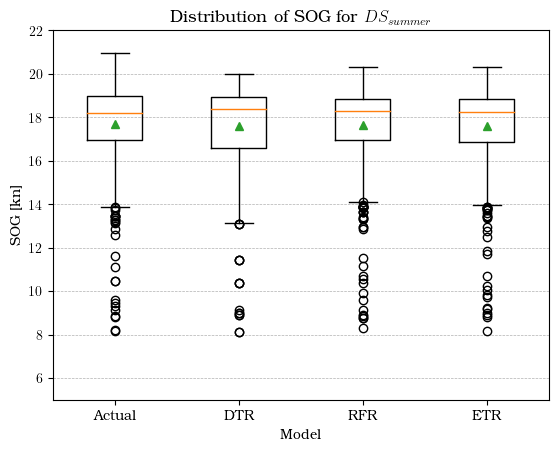

In [342]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [343]:
print(dfprog_sog_w.describe())
print(dfprog_sog_w.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

)) 

        sog_act_w  sog_pred_w  sog_pred_rf_w  sog_pred_dt_w  sog_pred_mlr_w  \
count  486.000000  486.000000     486.000000     486.000000      486.000000   
mean    17.401464   17.405156      17.403254      17.410011       17.264865   
std      2.130117    2.002343       2.041817       2.006112        1.505839   
min      8.034808    6.817429       6.710436       6.614699        7.630687   
25%     16.922608   16.992790      16.974415      17.096427       17.058516   
50%     18.057275   17.980386      18.009011      17.874676       17.577162   
75%     18.624666   18.557159      18.587860      18.578152       17.925989   
max     20.701952   19.865482      19.908851      19.996240       26.462117   

          gamma_w  nwinddir_w  
count  486.000000  486.000000  
mean   152.572902  205.146261  
std     99.475317   95.549274  
min      1.120417    1.009372  
25%     77.156028  149.018366  
50%    125.525598  211.994310  
75%    234.297045  280.877386  
max    359.264290  359.462360  


C:\Users\Wafi\AppData\Local\Temp\ipykernel_21272\3151661830.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_w.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

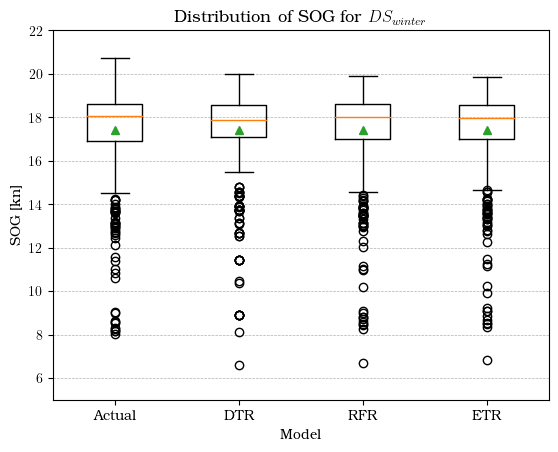

In [344]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [345]:
print(dfprog_sog_yr.describe())
print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

)) 

       sog_act_yr  sog_pred_yr  sog_pred_rf_yr  sog_pred_dt_yr  \
count  914.000000   914.000000      914.000000      914.000000   
mean    17.530370    17.500363       17.507377       17.502366   
std      2.148382     2.022365        2.055320        2.013766   
min      8.034808     6.827887        6.716033        6.614699   
25%     16.938559    16.965610       16.951505       16.984548   
50%     18.126637    18.114245       18.133545       18.154850   
75%     18.754099    18.699295       18.687232       18.664988   
max     20.935741    20.304657       20.314323       19.996240   

       sog_pred_mlr_yr    gamma_yr  nwinddir_yr  
count       914.000000  914.000000   914.000000  
mean         17.329456  152.259411   201.020086  
std           1.451884   99.443900    93.626045  
min           7.657439    0.587267     1.009372  
25%          17.173225   77.189636   141.752669  
50%          17.687471  125.294558   205.782268  
75%          17.988188  228.131645   278.803337  
max  

C:\Users\Wafi\AppData\Local\Temp\ipykernel_21272\2854589879.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_yr.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

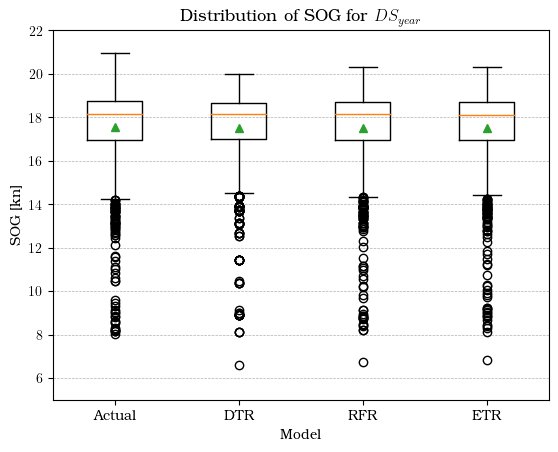

In [346]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [347]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [348]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [349]:
print(dfprog_yr.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        914.000000  914.000000  914.000000           914.000000   
mean         282.418549    3.682237  283.080962             0.763092   
std            6.500095    0.852515    5.721425             0.508798   
min          267.095032    1.734445  273.434815             0.070604   
25%          277.033936    3.050550  277.970215             0.383893   
50%          281.451538    3.580226  282.434631             0.646323   
75%          288.664612    4.227607  288.702148             0.980802   
max          296.022461    6.425161  294.751709             3.073458   

          draught         cog     heading   windspeed    curspeed  \
count  914.000000  914.000000  914.000000  914.000000  914.000000   
mean     5.223797  194.184104  189.091072    6.588308    0.099787   
std      0.183835   88.605155   89.876771    2.955519    0.069395   
min      4.742534   85.957578   87.138163    0.345946    0.001416   
25%   

In [350]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [351]:
print(dfprog_s.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        428.000000  428.000000  428.000000           428.000000   
mean         286.192811    3.654333  286.667389             0.769020   
std            5.910377    0.929812    5.008613             0.559502   
min          267.603760    1.967748  273.841797             0.070604   
25%          283.322083    2.948904  283.231201             0.366505   
50%          287.480835    3.492023  288.103271             0.624225   
75%          290.622070    4.192358  290.363281             0.963659   
max          296.022461    6.425161  294.751709             3.073458   

          draught         cog     heading   windspeed    curspeed  \
count  428.000000  428.000000  428.000000  428.000000  428.000000   
mean     5.286757  194.664533  189.331250    6.576387    0.098252   
std      0.163145   89.030063   89.648321    3.092907    0.074064   
min      4.742534   92.881843   87.138163    0.345946    0.001416   
25%   

In [352]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

In [353]:
# # Predicted SOG from RF model

# stw_pred_rf = sog_corr(dfprog_sog['sog_pred_rf'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_rf'] = stw_pred_rf

In [354]:
# # Predicted SOG from DT model

# stw_pred_dt = sog_corr(dfprog_sog['sog_pred_dt'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_dt'] = stw_pred_dt

In [355]:
# # Predicted SOG from MLR model

# stw_pred_mlr = sog_corr(dfprog_sog['sog_pred_mlr'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_mlr'] = stw_pred_mlr

In [356]:
# # Actual SOG

# stw_pred_act = sog_corr(dfprog_sog['sog_act'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_act'] = stw_pred_act

In [357]:
# dfprog.describe()

Holtrop Mennen FOC function

In [358]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = (1/16) * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl) * B

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    # print("Summary of important results")
    
    # print(f"Ship Displacement {dsp:0.4f} m^3")
    # print(f"Prismatic coefficient C_p {C_p:0.4f}")
    # print(f"Midship coefficient C_m {C_m:0.4f}")
    # print(f"Block coefficient C_b {C_b:0.4f}")
    # print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    # print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Max STW {stw.max():0.2f} kt")
    # print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    # print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    # print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    # print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    # print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    # print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    # print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    # print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    # print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    # print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    # print(f"Average Power {P_b.mean():0.3f} kW")
    # print(f"Max Power {P_b.max():0.3f} kW")
    # print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    # print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [359]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [360]:
def stats_HoltropMennen(stw,RFric,RApp,RWave,RBulb,RTrans,RCorr,RWind,RStaWave,RTot,EffTot,Pbrake,FOChr):
    WBM_desc_stats = pd.concat([stw,RFric/1e3,RApp/1e3,RWave/1e3,RBulb/1e3,pd.Series(RTrans/1e3),RCorr/1e3,RWind/1e3,pd.Series(RStaWave/1e3),RTot,EffTot,Pbrake,FOChr],axis=1)
    WBM_HM_desc = pd.DataFrame(WBM_desc_stats)
    WBM_HM_desc.columns = ['STW [m/s]','R_F [kN]', 'R_APP [kN]', 'R_W [kN]', 'R_B [kN]', 'R_TR [kN]' ,'R_A [kN]', 'R_AA [kN]' , 'R_AWL [kN]', 'R_TOT [kN]' , 'EFF_TOT [-]' ,'P_B[kW]','FOC [T/h]' ]
    # Direct print to LaTex, uncomment if needed
    # print(WBM_HM_desc.describe().transpose().to_latex(index=False,

    #               formatters={"name": str.upper},

    #               float_format="{:.2f}".format,
    # ))
    return WBM_HM_desc 


In [361]:
WBM_act_s = stats_HoltropMennen(stw_act_s,Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s)

In [362]:
WBM_act_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,17.731629,186.350224,42.047927,109.662584,72.781329,3.286559,47.359974,12.966723,4.056195,478.511515,0.666720,6734.637758,1.140848
std,2.151149,39.035884,8.965652,59.643312,6.923698,6.962240,10.248281,11.910626,11.352298,119.153974,0.000199,2256.060947,0.382177
min,7.970889,39.410127,8.612191,0.050885,31.523609,0.000000,9.391917,0.019386,0.000000,143.815385,0.666030,884.213316,0.149786
25%,16.953410,168.997459,37.962257,70.061640,70.099230,0.000000,42.709759,3.118472,0.000000,410.186174,0.666626,5327.996765,0.902563
50%,18.232411,194.047242,43.801623,108.673926,74.481217,0.000000,49.368951,9.984143,0.000000,488.058568,0.666746,6895.761086,1.168142
75%,19.069633,210.926545,47.846636,141.474681,77.293127,3.299777,53.878009,19.811368,1.691914,550.784025,0.666848,8084.564471,1.369525
max,21.800027,265.380908,62.259554,330.258379,83.013188,41.511663,70.124126,56.583546,108.784311,820.744093,0.667455,13817.738045,2.340725


Actual Winter

In [363]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [364]:
WBM_act_w = stats_HoltropMennen(stw_act_w,Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w)

In [365]:
WBM_act_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,17.446128,179.127926,40.728152,96.378064,74.124309,3.555108,45.764159,12.728457,2.186864,454.593039,0.666590,6279.636564,1.063770
std,2.118910,36.577539,8.456856,46.666752,6.677722,7.542054,9.634796,10.862180,6.413676,102.044863,0.000227,1903.749998,0.322495
min,8.128237,40.924280,8.949295,0.063806,38.850336,0.000000,9.773824,0.012765,0.000000,140.054518,0.666024,877.875824,0.148712
25%,16.914009,167.584207,37.788909,68.683364,72.684333,0.000000,42.491189,3.647915,0.000000,403.261504,0.666456,5269.010043,0.892570
50%,18.051505,187.841846,42.950727,101.215692,76.216980,0.000000,48.251272,10.415065,0.000000,471.134500,0.666607,6579.527779,1.114572
75%,18.669305,201.336376,45.890508,124.255440,78.123986,3.467388,51.764013,20.079451,0.420015,519.222647,0.666747,7455.066514,1.262888
max,20.832180,247.308062,56.936992,259.203044,83.527096,40.842302,64.257625,51.230868,51.270553,740.649523,0.667172,11910.984414,2.017721


Actual Year

In [366]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [367]:
WBM_act_yr = stats_HoltropMennen(stw_act_yr,Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr)

In [368]:
WBM_act_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,17.579820,182.509921,41.346165,102.598824,73.495430,3.429354,46.511433,12.840030,3.063855,465.795012,0.666651,6492.667532,1.099858
std,2.137654,37.899721,8.718950,53.521824,6.823299,7.273588,9.953254,11.359509,9.108932,110.948087,0.000224,2087.290014,0.353587
min,7.970889,39.410127,8.612191,0.050885,31.523609,0.000000,9.391917,0.012765,0.000000,143.580846,0.666024,884.213316,0.149786
25%,16.947019,168.141495,37.934113,69.652101,71.232331,0.000000,42.643023,3.331751,0.000000,404.288917,0.666499,5283.157415,0.894967
50%,18.161710,190.784214,43.468094,104.701791,75.460022,0.000000,48.851494,10.251385,0.000000,482.228289,0.666685,6738.110761,1.141436
75%,18.836986,205.675837,46.704953,131.972118,77.844972,3.326964,52.605779,19.920758,0.915133,528.978066,0.666801,7699.335996,1.304268
max,21.800027,265.380908,62.259554,330.258379,83.527096,41.511663,70.124126,56.583546,108.784311,820.744093,0.667455,13817.738045,2.340725


ETR Year

In [369]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [370]:
WBM_etr_yr = stats_HoltropMennen(stw_pred_et_yr,Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr)

In [371]:
WBM_etr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,17.549842,181.657652,41.142316,98.758984,73.496233,3.207306,46.276196,12.791503,3.063855,460.394044,0.666651,6380.692615,1.080889
std,2.008681,35.198351,8.070860,45.038891,6.647473,7.090589,9.213209,11.269262,9.108932,98.326937,0.000223,1829.882220,0.309982
min,6.809161,29.522836,6.320653,0.005280,30.331299,0.000000,6.870340,0.006296,0.000000,124.079499,0.666078,651.398336,0.110347
25%,16.966925,167.804506,38.021829,69.443966,71.326683,0.000000,42.659564,3.410694,0.000000,409.278745,0.666496,5343.060963,0.905115
50%,18.124849,190.249210,43.294702,103.412124,75.361835,0.000000,48.633777,10.113873,0.000000,478.911864,0.666682,6711.860566,1.136989
75%,18.762597,204.485745,46.342765,128.672172,77.701657,3.242284,52.220666,19.736211,0.915133,525.906018,0.666796,7616.086592,1.290165
max,20.828384,253.216348,56.916580,269.931689,82.204326,46.453688,64.560193,55.889539,108.784311,729.281951,0.667464,11718.822655,1.985169


ETR summer

In [372]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [373]:
WBM_etr_s = stats_HoltropMennen(stw_pred_et_s,Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s)

In [374]:
WBM_etr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,17.662041,184.711107,41.661800,103.781591,72.680858,3.151708,46.915796,12.891889,4.056195,469.850944,0.666722,6558.473252,1.111005
std,2.023879,36.151086,8.274106,48.990392,6.823805,6.892812,9.456118,11.808887,11.352298,104.023157,0.000198,1943.322400,0.329199
min,8.361532,44.614845,9.460824,0.087024,31.200298,0.000000,10.405099,0.006296,0.000000,151.847101,0.666090,991.210224,0.167911
25%,16.933952,167.760161,37.876605,69.269080,70.402892,0.000000,42.613136,3.176642,0.000000,410.439696,0.666624,5357.048630,0.907484
50%,18.296762,194.757415,44.106291,111.032989,74.413663,0.000000,49.671141,9.970678,0.000000,496.330204,0.666754,7014.717743,1.188293
75%,18.896513,207.961882,46.995789,135.307688,77.218391,3.382552,52.938649,19.189082,1.691914,533.979845,0.666851,7793.458342,1.320212
max,20.828384,253.216348,56.916580,269.931689,81.745876,39.849858,64.560193,55.889539,108.784311,729.281951,0.667460,11718.822655,1.985169


ETR winter

In [375]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [376]:
WBM_etr_w = stats_HoltropMennen(stw_pred_et_w,Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w)

In [377]:
WBM_etr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,17.449853,178.938804,40.677839,94.273810,74.213684,3.253934,45.704882,12.701831,2.186864,451.951648,0.666589,6221.990897,1.054005
std,1.988790,34.113867,7.859845,40.747612,6.395274,7.255312,8.957036,10.783950,6.413676,92.305199,0.000225,1709.436313,0.289579
min,6.798703,29.436773,6.301606,0.005158,30.261165,0.000000,6.849253,0.020300,0.000000,119.399585,0.666078,625.865692,0.106022
25%,17.006307,167.804506,38.195609,69.838222,72.926949,0.000000,42.769097,3.719443,0.000000,408.978892,0.666450,5365.012836,0.908833
50%,18.040059,187.035488,42.897154,99.797584,76.239118,0.000000,48.120633,10.374718,0.000000,467.865748,0.666610,6519.910166,1.104473
75%,18.610398,199.637305,45.606064,121.168107,78.102486,3.074749,51.315395,19.955971,0.420015,515.862941,0.666753,7395.783989,1.252846
max,20.032094,230.751682,52.714045,197.253673,82.204326,46.498176,59.416618,49.589594,51.270553,649.229289,0.667248,10039.409809,1.700676


RFR year

In [378]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [379]:
WBM_rfr_yr = stats_HoltropMennen(stw_pred_rf_yr,Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr)

In [380]:
WBM_rfr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,17.556844,181.863545,41.191277,99.426109,73.492620,3.239936,46.332709,12.805032,3.063855,461.415083,0.666651,6401.627838,1.084436
std,2.042090,35.705151,8.190431,45.782356,6.730705,7.201112,9.348332,11.286158,9.108932,99.859160,0.000223,1858.648750,0.314855
min,6.697310,28.608538,6.118407,0.004096,29.579518,0.000000,6.646482,0.003702,0.000000,122.452501,0.666049,632.284958,0.107109
25%,16.974597,167.762823,38.055635,69.918708,71.536781,0.000000,42.782810,3.388000,0.000000,408.831234,0.666496,5373.938127,0.910345
50%,18.146830,190.301578,43.398063,103.873043,75.423512,0.000000,48.810039,10.190913,0.000000,478.892573,0.666684,6704.124734,1.135679
75%,18.758509,204.237655,46.322902,128.446020,77.706500,3.209647,52.213708,19.804671,0.915133,526.732826,0.666797,7632.909978,1.293015
max,20.850657,253.732366,57.036412,271.877260,82.555007,46.929506,64.698344,56.014436,108.784311,732.065281,0.667454,11776.139792,1.994878


RFR Summer


In [381]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [382]:
WBM_rfr_s = stats_HoltropMennen(stw_pred_rf_s,Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s)

In [383]:
WBM_rfr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,17.680481,185.125476,41.758217,104.836330,72.716502,3.159017,47.026700,12.914595,4.056195,471.593033,0.666721,6593.206311,1.116889
std,2.047094,36.598784,8.377663,49.951502,6.816513,6.944088,9.574541,11.830376,11.352298,105.686290,0.000198,1975.706004,0.334685
min,8.516146,46.195733,9.807539,0.109808,32.040306,0.000000,10.793461,0.003702,0.000000,151.598386,0.666108,1027.304512,0.174025
25%,16.944580,167.614165,37.923504,68.561505,70.404190,0.000000,42.510254,3.128499,0.000000,408.664497,0.666629,5351.513348,0.906546
50%,18.305899,195.120301,44.149633,110.687334,74.554596,0.000000,49.700035,9.987285,0.000000,495.473093,0.666751,7009.786068,1.187458
75%,18.927389,208.077241,47.146982,135.542935,77.241607,3.337341,53.097723,19.358251,1.691914,538.167115,0.666854,7846.748315,1.329239
max,20.850657,253.732366,57.036412,271.877260,81.450475,39.192125,64.698344,56.014436,108.784311,732.065281,0.667447,11776.139792,1.994878


RFR winter

In [384]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [385]:
WBM_rfr_w = stats_HoltropMennen(stw_pred_rf_w,Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w)

In [386]:
WBM_rfr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,17.447965,178.980545,40.689531,94.624559,74.179412,3.305766,45.718638,12.707844,2.186864,452.393158,0.666590,6231.812141,1.055669
std,2.028722,34.631856,7.985983,41.211850,6.559556,7.406574,9.097875,10.796532,6.413676,93.591911,0.000226,1732.552684,0.293494
min,6.691713,28.563145,6.108371,0.004043,29.541803,0.000000,6.635377,0.017106,0.000000,117.844554,0.666049,607.982653,0.102992
25%,16.986304,167.805408,38.107281,70.011553,72.968220,0.000000,42.811279,3.648354,0.000000,409.540582,0.666447,5398.515116,0.914508
50%,18.025364,187.250574,42.828434,99.804212,76.291190,0.000000,48.115012,10.362249,0.000000,467.107721,0.666610,6520.375368,1.104552
75%,18.612509,199.958514,45.616243,120.819587,78.160472,3.159845,51.363241,20.077213,0.420015,514.279593,0.666753,7378.204449,1.249868
max,20.237812,233.591927,53.784535,212.121634,82.555007,46.953316,60.643232,49.945354,51.270553,671.588783,0.667260,10491.921254,1.777331


DTR Yearly

In [387]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [388]:
WBM_dtr_yr = stats_HoltropMennen(stw_pred_dt_yr,Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr)

In [389]:
WBM_dtr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,17.551871,181.691838,41.148465,98.647895,73.508628,3.213634,46.283527,12.759823,3.063855,460.317664,0.666651,6378.910644,1.080587
std,2.002576,35.141639,8.046987,44.416385,6.602486,7.080341,9.188462,11.203053,9.108932,97.451088,0.000222,1812.303609,0.307004
min,6.595978,27.792027,5.937973,0.003231,28.895404,0.000000,6.446877,0.007512,0.000000,120.994463,0.666119,615.292887,0.104231
25%,17.069310,168.164556,38.474451,71.082564,71.571306,0.000000,43.014155,3.372845,0.000000,404.828067,0.666499,5336.050270,0.903927
50%,18.199693,190.880460,43.647123,105.784665,75.269485,0.000000,49.062783,10.121698,0.000000,480.167146,0.666681,6743.686536,1.142380
75%,18.745174,203.973522,46.258136,127.690203,77.739416,2.806736,52.107108,19.432337,0.915133,528.530061,0.666796,7644.108926,1.294912
max,21.140509,260.493170,58.607171,297.444319,82.477888,47.360575,66.509628,56.819348,108.784311,768.599384,0.667389,12535.877118,2.123578


DTR summer

In [390]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [391]:
WBM_dtr_s = stats_HoltropMennen(stw_pred_dt_s,Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s)

In [392]:
WBM_dtr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,17.662088,184.689925,41.654816,103.304641,72.684083,3.152606,46.907848,12.846230,4.056195,469.296343,0.666722,6546.894392,1.109044
std,2.009622,35.835651,8.189298,47.493924,6.764821,6.873799,9.360856,11.709414,11.352298,101.928760,0.000197,1901.445887,0.322105
min,8.058375,40.756201,8.798834,0.056647,35.687658,0.000000,9.627513,0.008012,0.000000,138.797871,0.666119,862.460745,0.146101
25%,16.605638,163.303495,36.445655,60.815651,70.687961,0.000000,40.975745,3.065349,0.000000,400.043089,0.666627,5120.174856,0.867358
50%,18.330974,194.410362,44.268689,110.738950,74.435879,0.000000,49.756726,9.949882,0.000000,495.141155,0.666758,7001.261989,1.186014
75%,18.925365,208.787841,47.137061,136.402990,77.296171,4.779210,53.205958,19.213796,1.691914,536.761995,0.666861,7843.334943,1.328661
max,21.140509,260.493170,58.607171,297.444319,82.477888,41.139499,66.509628,56.819348,108.784311,768.599384,0.667389,12535.877118,2.123578


DTR Winter

In [393]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [394]:
WBM_dtr_w = stats_HoltropMennen(stw_pred_dt_w,Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w)

In [395]:
WBM_dtr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,17.454807,179.051547,40.702542,94.546893,74.234770,3.267380,45.733714,12.683727,2.186864,452.407437,0.666589,6231.046109,1.055539
std,1.993372,34.339411,7.901121,41.132250,6.375256,7.264011,9.007755,10.748966,6.413676,92.769706,0.000224,1718.721452,0.291151
min,6.595978,27.792027,5.937973,0.003231,28.895404,0.000000,6.446877,0.007512,0.000000,116.467448,0.666130,592.271669,0.100331
25%,17.088278,169.695770,38.558598,72.533331,72.841661,0.000000,43.264608,3.625219,0.000000,409.738397,0.666442,5427.645557,0.919443
50%,18.026608,188.189861,42.834251,100.745402,76.363696,0.000000,48.233214,10.266786,0.000000,469.933348,0.666604,6518.952006,1.104310
75%,18.637764,200.555832,45.738098,121.958307,78.127562,2.726045,51.434818,19.714560,0.420015,514.077414,0.666745,7384.828044,1.250990
max,20.290250,237.930278,54.059101,218.222199,81.863766,47.360575,61.042754,50.472676,51.270553,669.386721,0.667271,10483.021616,1.775824


MLR Yearly data

In [396]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

MLR Summer

In [397]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

MLR Winter

In [398]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Best fit of results using polynomial regression

In [399]:
# Function to check possible best fit of polynomial regression

def poly_reg_best_fit(DataSet,STW,FOC):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from matplotlib.ticker import MultipleLocator,FixedLocator
    from matplotlib.transforms import ScaledTranslation

    plt.rcParams['figure.dpi'] = 300

    sorted_Xreg = np.sort(STW)
    sorted_Yreg = np.sort(FOC)

    Xreg = sorted_Xreg.reshape(-1,1)
    Yreg = sorted_Yreg

    Xreg_train, Xreg_test, Yreg_train, Yreg_test = train_test_split(Xreg, Yreg, test_size=0.25, random_state=42)

    train_errors = []
    test_errors = []
    coefficients_list = []
    scores_poly = []


    # Loop through different orders
    for order in range(1, 6):
        # Create polynomial features for the current order
        poly = PolynomialFeatures(degree=order)
        X_poly_train = poly.fit_transform(Xreg_train)
        X_poly_test = poly.transform(Xreg_test)

        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_poly_train, Yreg_train)

        # Make predictions on training and test data
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)

        # Calculate the score (R-squared) of the model
        score = model.score(X_poly_test, Yreg_test)

        # Calculate mean squared errors for training and test data
        train_error = mean_squared_error(Yreg_train, y_pred_train)
        test_error = mean_squared_error(Yreg_test, y_pred_test)

        # Append the errors to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        coefficients_list.append(model.coef_)
        scores_poly.append(score)
        # # Uncomment to get each order's performance
        # print(score)
        # print(test_error)
    
    # # Find the best model (lowest test error)
    
    # best_order = np.argmin(test_errors)
    
    # Brute force, seems that there is a bug with summer dataset actual dataset, in general order 4 is the most acceptable performance  
    best_order = 4
    
    best_coefficients = coefficients_list[best_order]

    # Create polynomial features for the best model
    poly = PolynomialFeatures(degree=best_order)
    X_poly = poly.fit_transform(Xreg)

    # Fit the best model on the entire dataset
    best_model = LinearRegression()
    best_model.fit(X_poly, Yreg)

    # Get coefficients of the best model
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # # Print the polynomial equation
    # equation = "y = {:.4f}".format(best_model.intercept_)
    # for i, coef in enumerate(best_coefficients[1:], 1):
    #     equation += " + {:.4f}x^{}".format(coef, i)

    # print("Best Polynomial Equation:")
    # print(equation)

    # LaTeX format for polynomial equation
    def format_equation(coefficients, intercept):
        equation = f"$y = {intercept:.4f}"
        for i, coef in enumerate(coefficients[1:], 1):
            equation += f" + ({coef:.4f})x^{i}"
        equation += "$"
        return equation
    
    # Print the best polynomial equation
    equation = format_equation(coefficients, intercept)
    print("Best Polynomial Equation:")
    print(equation)
    # print(score.max())
    # get score for the 4th order
    Rsquared = scores_poly[3]

    # Generate points for plotting the best-fitted line
    X_plot = np.linspace(Xreg.min(), Xreg.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = best_model.predict(X_plot_poly)

    # Plot the original data points and the best-fitted line
    # Follow definition from 3rd GHG study
    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # Actual Plot
    plt.scatter(STW, FOC,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    # Temporary plot for actual STW 
    # plt.scatter(STW, FOC,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12)
    plt.plot(X_plot, y_plot, color='black',label='Regression',linewidth=.8)
    plt.title(f'Regression fit for ${DataSet}$')
    plt.xlabel('STW [kn]')
    plt.ylabel('FOC [T/h]')
    # plt.xticks(range(6, 22, 1))
    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=0.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=0.6,fontsize=6)
    plt.text(4.2, -.25, equation, bbox=dict(facecolor='white', alpha=0.9),fontsize=12)
    plt.text(5.6, 1.5, rf'$R^2$ = {Rsquared:0.4f}', bbox=dict(facecolor='white', alpha=0.9),fontsize=14)

    # plt.grid(linestyle = '--', linewidth = 0.25,which='both')
    plt.legend(loc='upper left')
    # plt.show()

    # orders = range(1, 6)
    # plt.plot(orders, train_errors, label='Train Error')
    # plt.plot(orders, test_errors, label='Test Error',linestyle='-.')
    # plt.xlabel('Polynomial Order')
    # plt.ylabel('Mean Squared Error')
    # plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend()
    # plt.show()
    # print(plt.rcParams['figure.dpi'])
    
    return best_model


Scatter plot actual predicted FOC

In [400]:
def FOC_coeff_plot(model,stw_predicted,stw_actual,FOC_predicted,FOC_actual):
    from matplotlib.ticker import MultipleLocator,FixedLocator


    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    plt.scatter(Xa, Ya,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12,alpha=0.5)
    plt.scatter(Xp, Yp,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    plt.title(f"FOC Plot {model}")
    plt.xlabel(r'STW [$kn$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)


    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    # plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend()
    # plt.show()

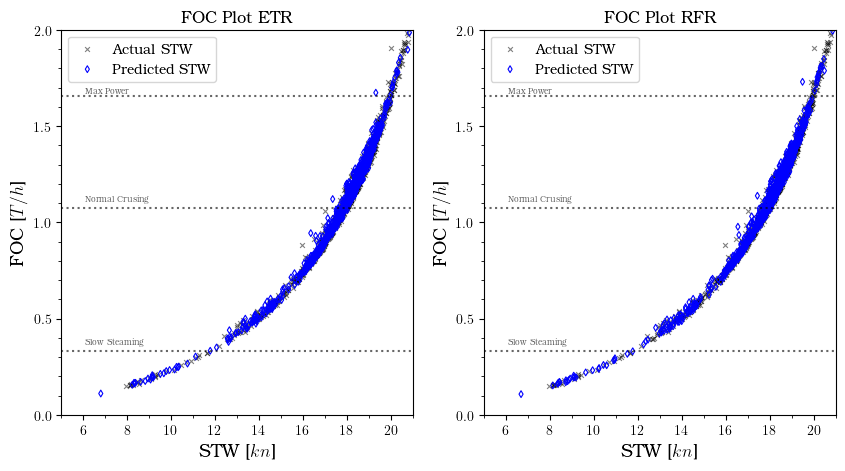

In [401]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('ETR',stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('RFR',stw_pred_rf_yr,stw_act_yr,FOC_pred_rf_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

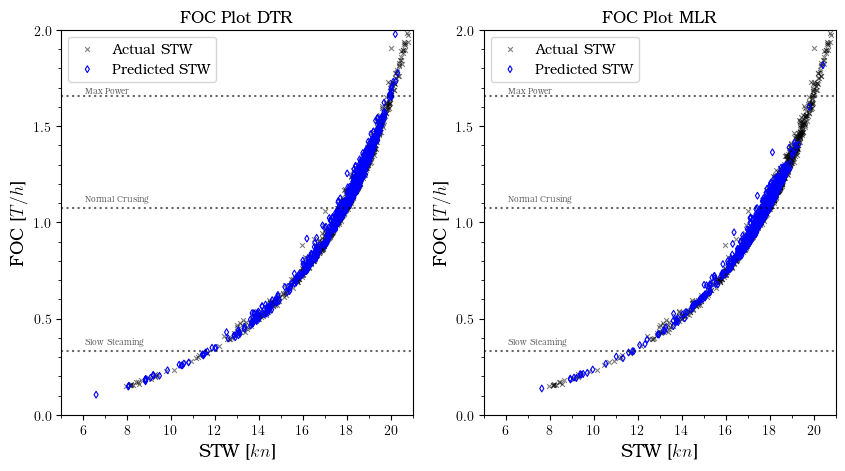

In [402]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('DTR',stw_pred_dt_yr,stw_act_yr,FOC_pred_dt_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('MLR',stw_pred_mlr_yr,stw_act_yr,FOC_pred_mlr_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

Actual data polyfit

In [403]:
# poly_act_yr = poly_reg_best_fit(stw_act_yr,FOC_act_yr)
# poly_act_w = poly_reg_best_fit(stw_act_w,FOC_act_w)
# poly_act_s = poly_reg_best_fit(stw_act_s,FOC_act_s)

Best Polynomial Equation:
$y = 1.1792 + (-0.4123)x^1 + (0.0562)x^2 + (-0.0032)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 2.1399 + (-0.7109)x^1 + (0.0896)x^2 + (-0.0048)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.7373 + (-0.2691)x^1 + (0.0394)x^2 + (-0.0023)x^3 + (0.0001)x^4$


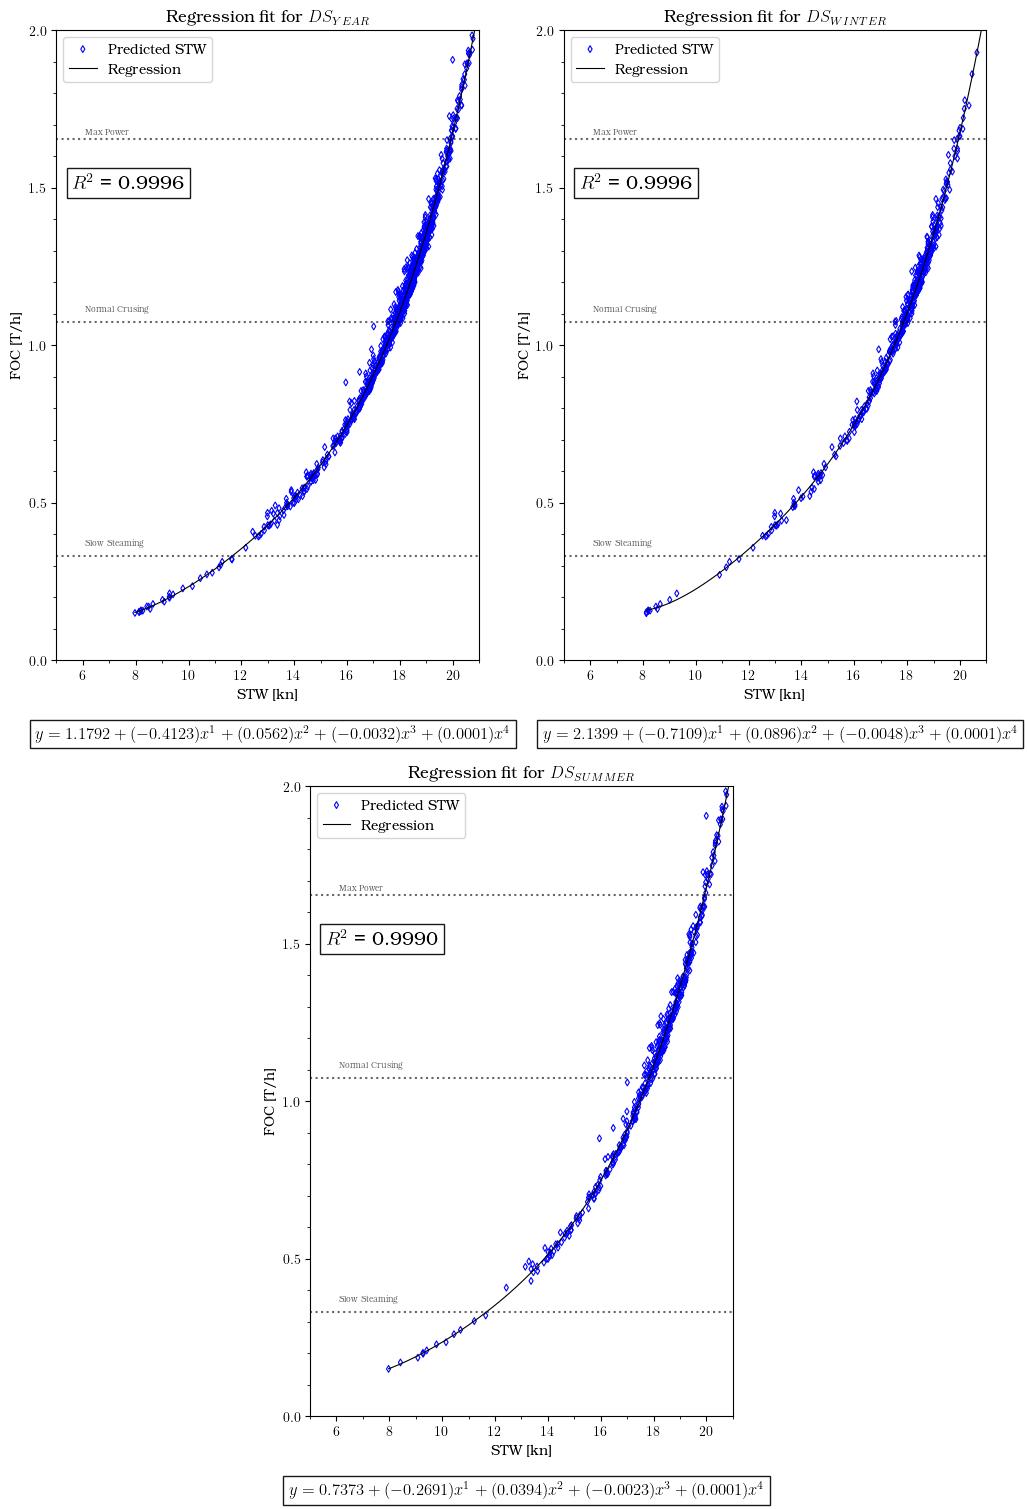

In [404]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_act_yr = poly_reg_best_fit('DS_{YEAR}',stw_act_yr,FOC_act_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_act_s = poly_reg_best_fit('DS_{WINTER}',stw_act_w,FOC_act_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_act_w = poly_reg_best_fit('DS_{SUMMER}',stw_act_s,FOC_act_s)
plt.show()

ETR polyfit plot

Best Polynomial Equation:
$y = 0.9592 + (-0.3442)x^1 + (0.0484)x^2 + (-0.0028)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.0047 + (-0.3709)x^1 + (0.0528)x^2 + (-0.0031)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.4359 + (-0.4603)x^1 + (0.0582)x^2 + (-0.0031)x^3 + (0.0001)x^4$


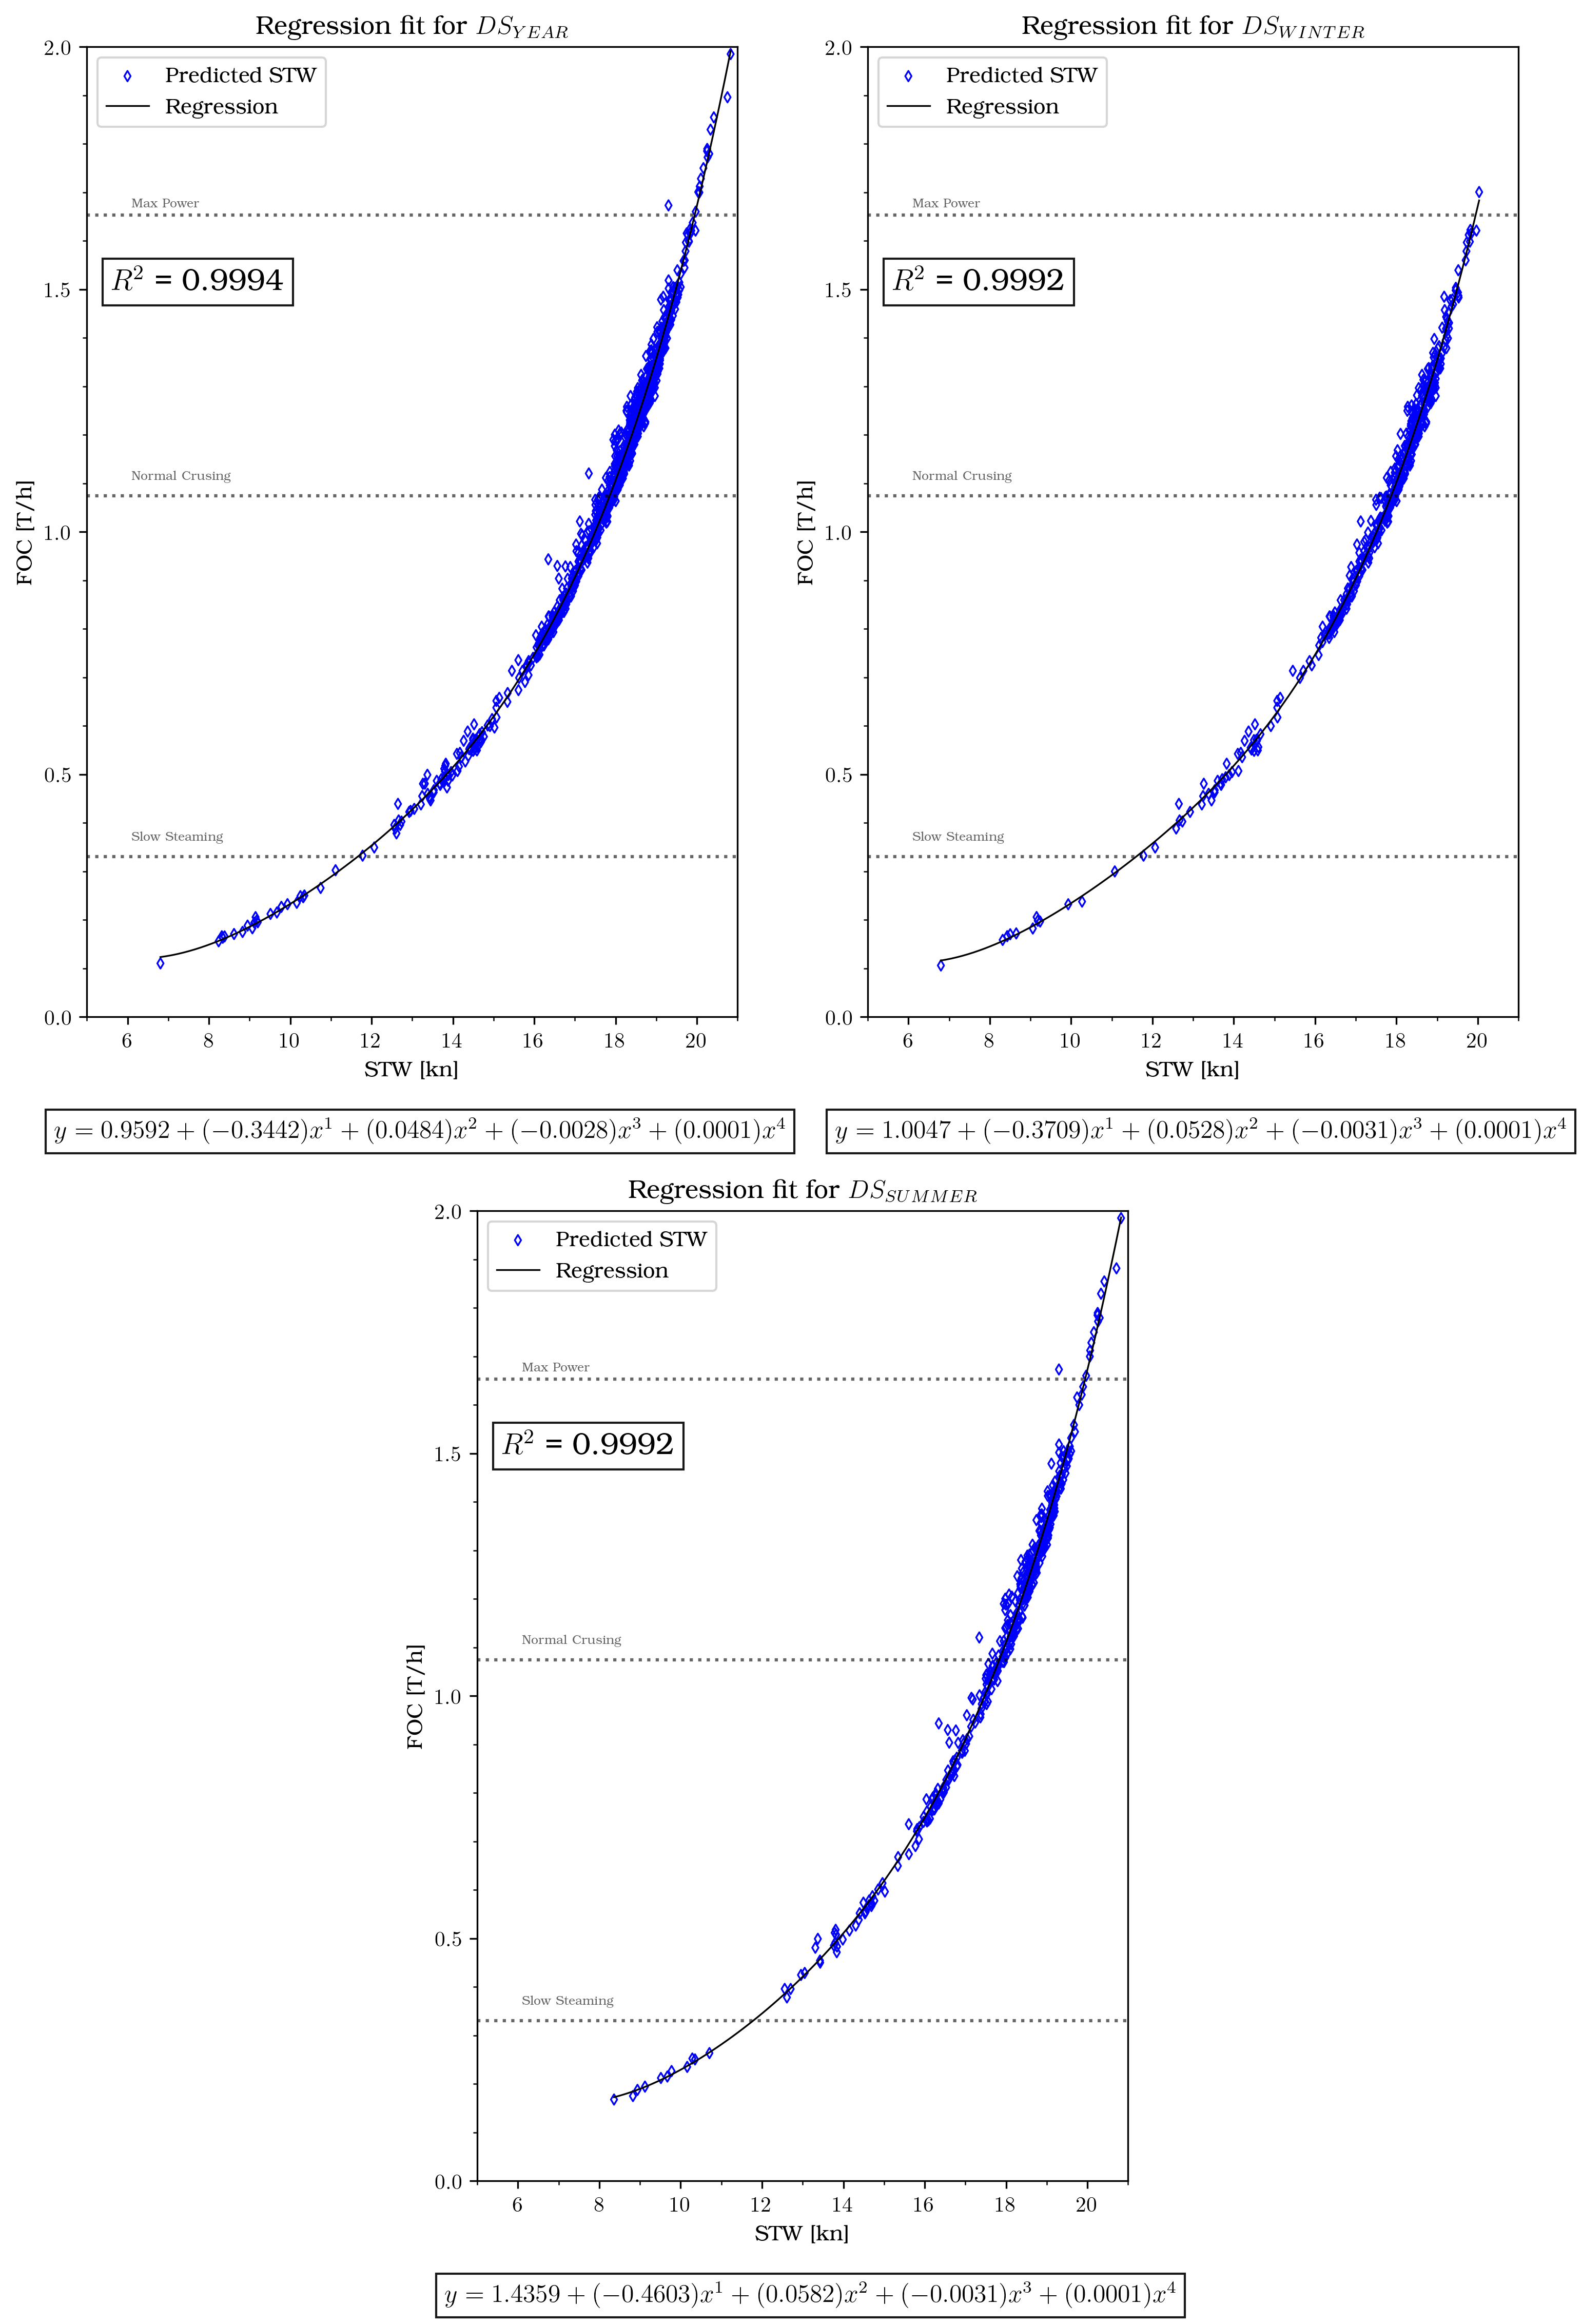

In [405]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_etr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_et_yr,FOC_pred_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_etr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_et_w,FOC_pred_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_etr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_et_s,FOC_pred_s)
plt.show()

RFR polyfit FOC

Best Polynomial Equation:
$y = 0.9500 + (-0.3426)x^1 + (0.0484)x^2 + (-0.0028)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.0826 + (-0.3963)x^1 + (0.0558)x^2 + (-0.0032)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.2495 + (-0.4068)x^1 + (0.0526)x^2 + (-0.0029)x^3 + (0.0001)x^4$


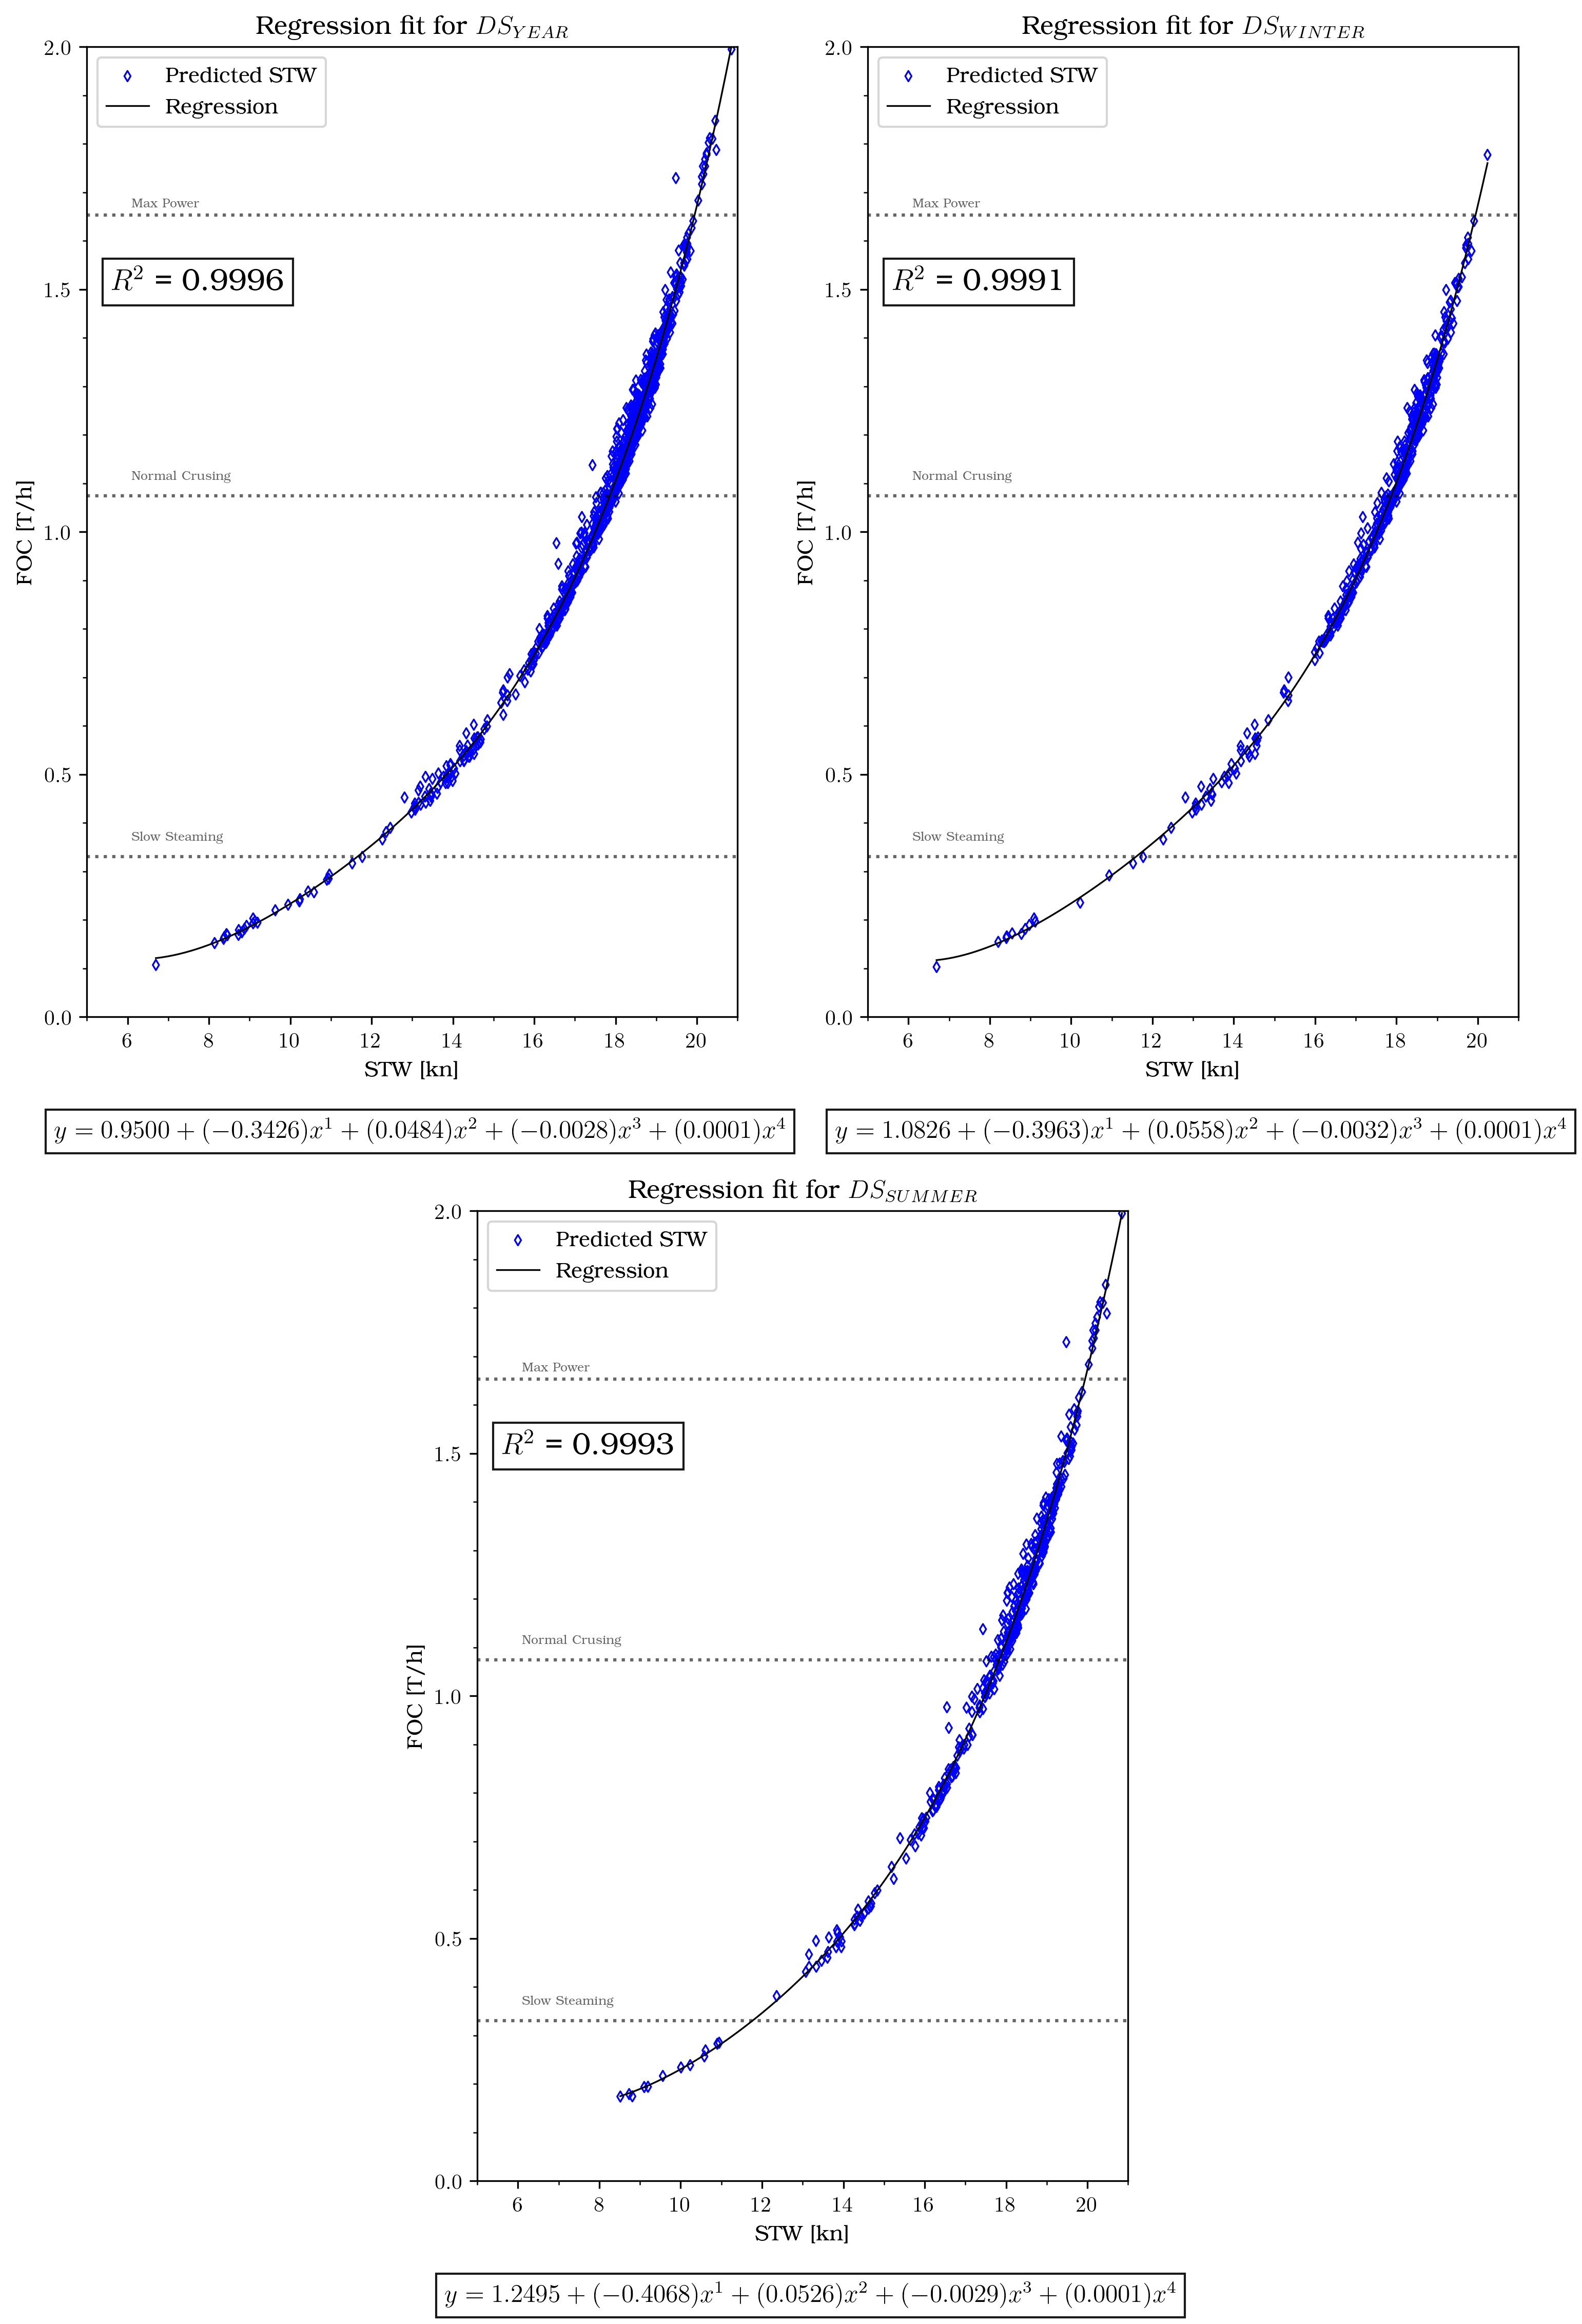

In [406]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_rfr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_rf_w,FOC_pred_rf_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_rfr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_rf_s,FOC_pred_rf_s)
plt.show()

DTR

Best Polynomial Equation:
$y = 1.2834 + (-0.4507)x^1 + (0.0609)x^2 + (-0.0034)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.1571 + (-0.4222)x^1 + (0.0589)x^2 + (-0.0034)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 1.9661 + (-0.6272)x^1 + (0.0771)x^2 + (-0.0040)x^3 + (0.0001)x^4$


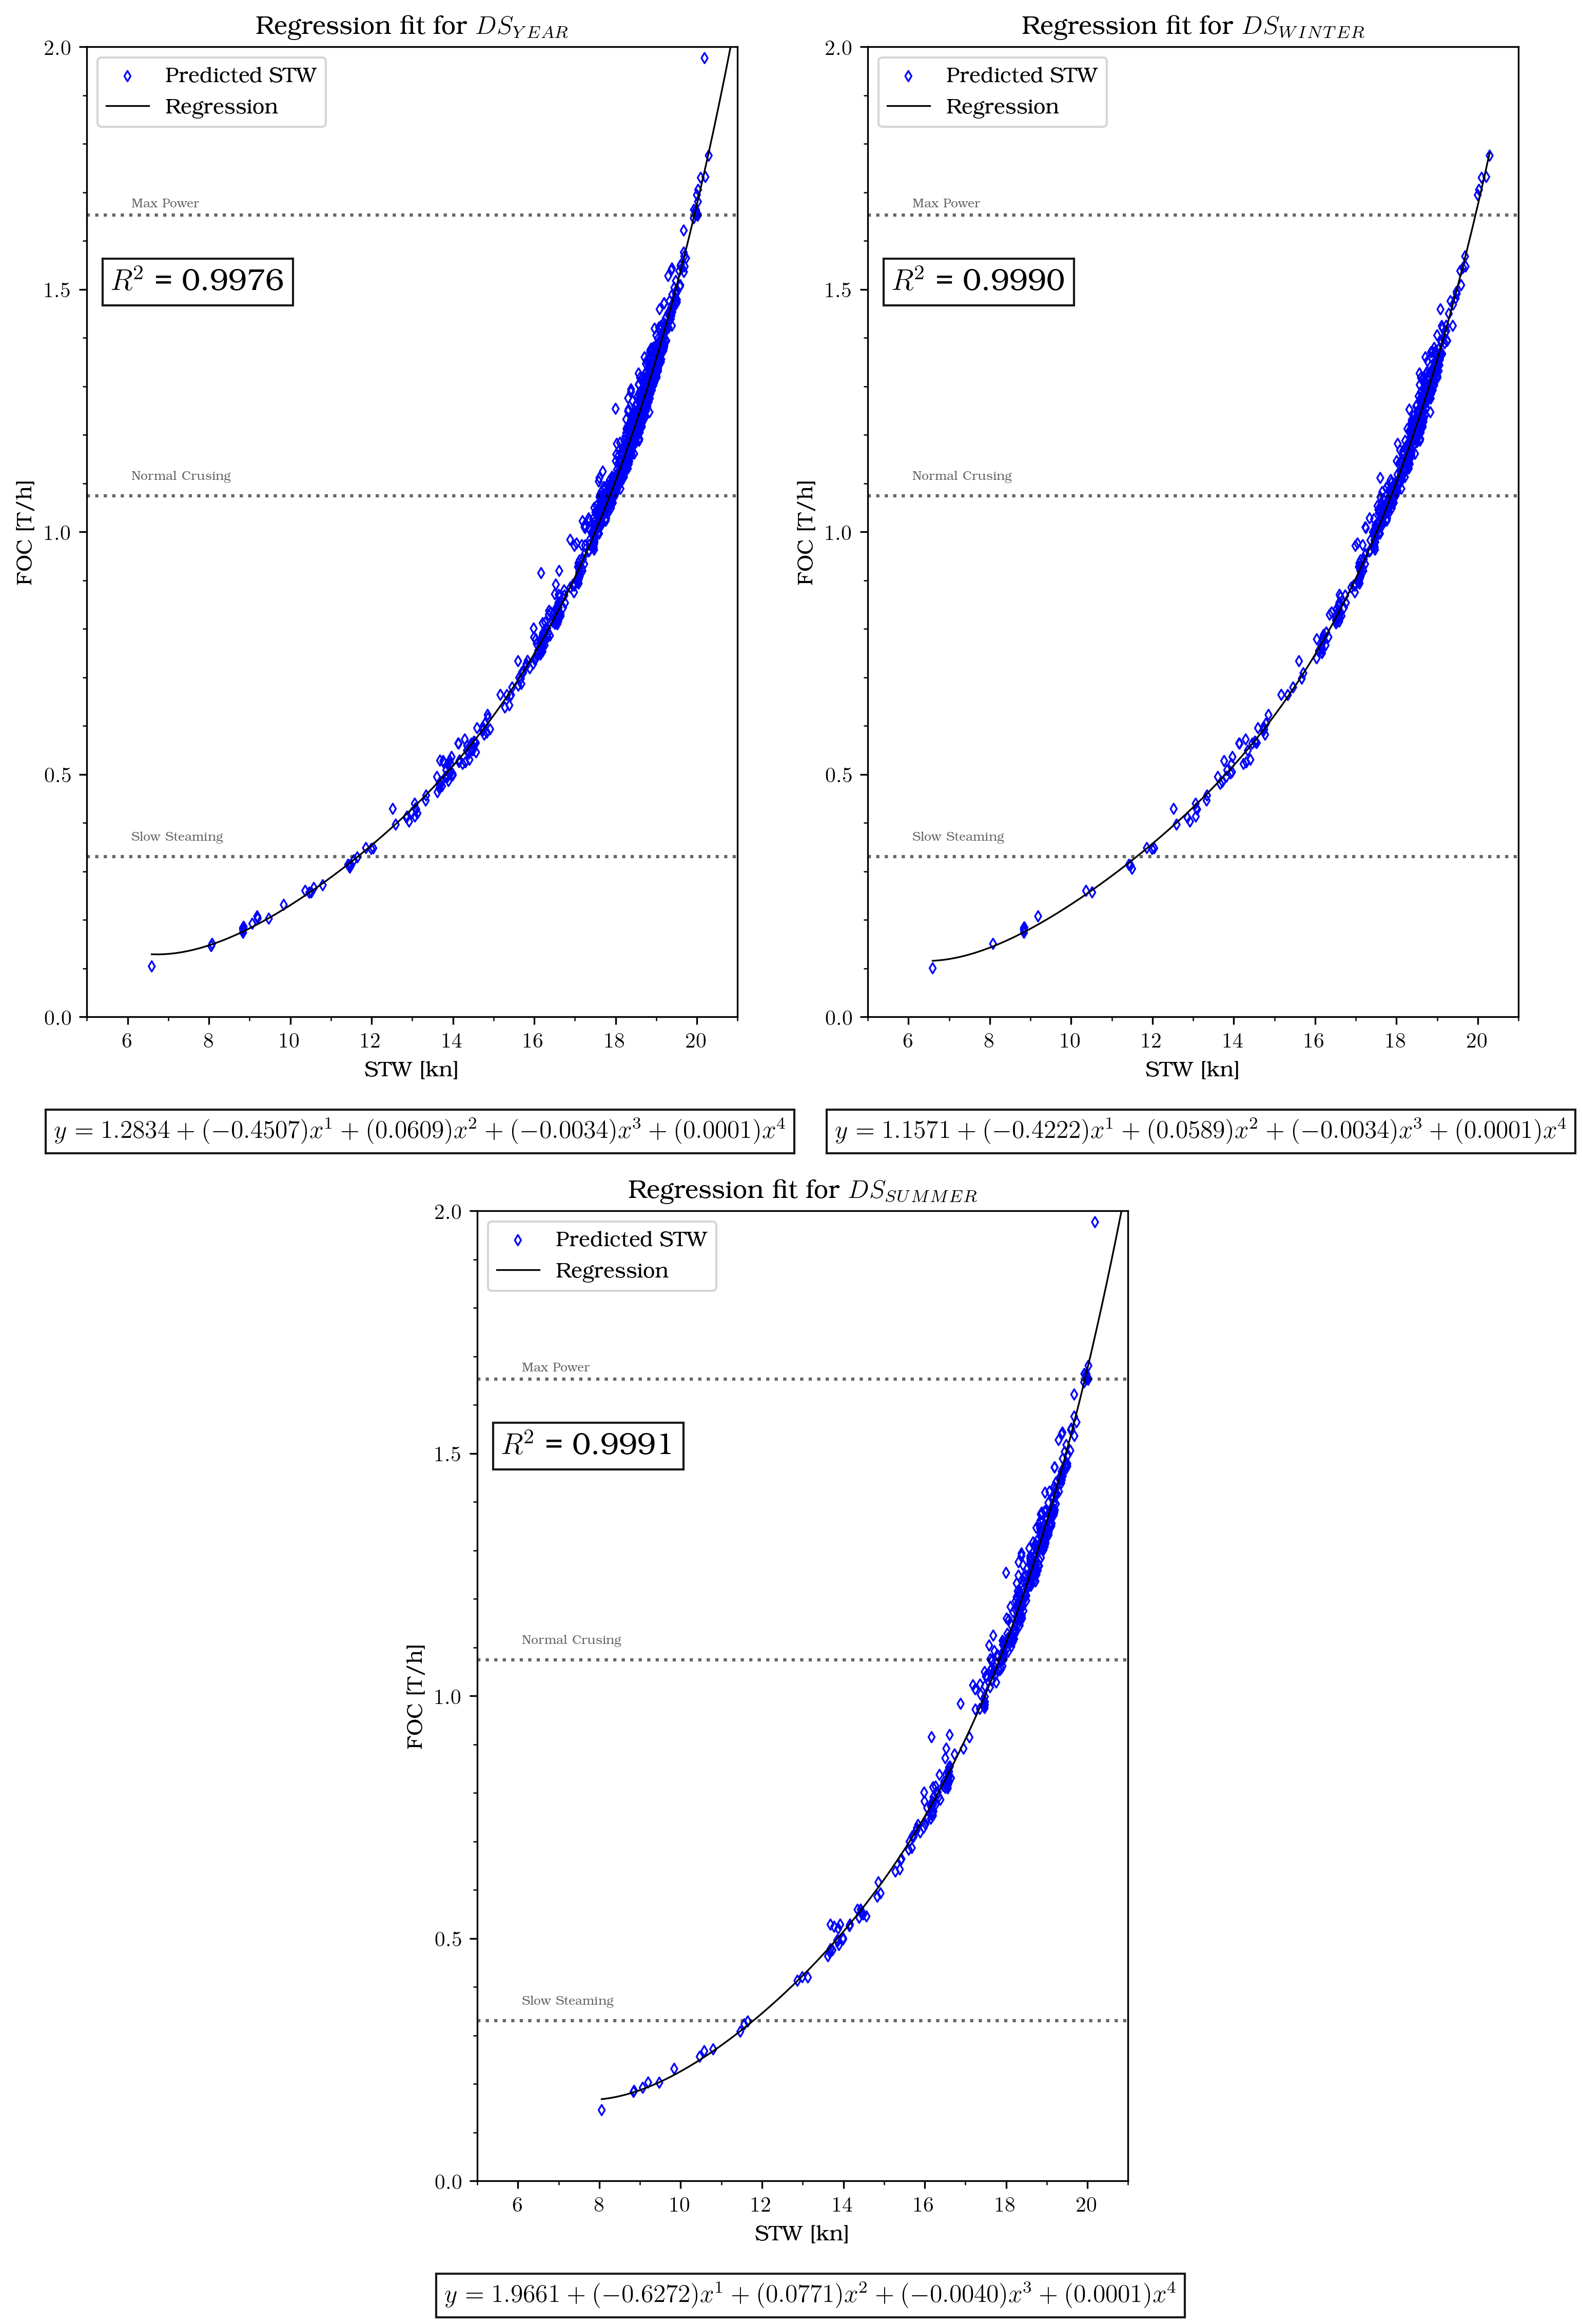

In [407]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_dtr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_dt_yr,FOC_pred_dt_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_dtr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_dt_w,FOC_pred_dt_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_dtr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_dt_s,FOC_pred_dt_s)
plt.show()

Absolute model performance

In [408]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [409]:
# Yearly performance 

evaluate_FOC(model_etr_hpov,FOC_act_yr,FOC_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8846
Explained Variance 0.8874
MAE 0.0754 T/h
RMSE FOC 0.1201 T/h
MAD 0.0439 T/h
MAPE FOC 7.2138 %


In [410]:
evaluate_FOC(model_etr_hpov,FOC_act_s,FOC_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8637
Explained Variance 0.8698
MAE 0.0881 T/h
RMSE FOC 0.1409 T/h
MAD 0.0525 T/h
MAPE FOC 8.1251 %


In [411]:
evaluate_FOC(model_etr_hpov,FOC_act_w,FOC_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.9064
Explained Variance 0.9073
MAE 0.0647 T/h
RMSE FOC 0.0986 T/h
MAD 0.0405 T/h
MAPE FOC 6.4490 %


RFR

In [412]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr,FOC_pred_rf_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8841
Explained Variance 0.8860
MAE 0.0724 T/h
RMSE FOC 0.1203 T/h
MAD 0.0419 T/h
MAPE FOC 7.0538 %


In [413]:
evaluate_FOC(model_rfr_hpov,FOC_act_s,FOC_pred_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8558
Explained Variance 0.8597
MAE 0.0855 T/h
RMSE FOC 0.1450 T/h
MAD 0.0444 T/h
MAPE FOC 8.2295 %


In [414]:
evaluate_FOC(model_rfr_hpov,FOC_act_w,FOC_pred_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.9156
Explained Variance 0.9162
MAE 0.0610 T/h
RMSE FOC 0.0936 T/h
MAD 0.0367 T/h
MAPE FOC 6.0312 %


DTR

In [415]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr,FOC_pred_dt_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.6861
Explained Variance 0.6890
MAE 0.1366 T/h
RMSE FOC 0.1980 T/h
MAD 0.0890 T/h
MAPE FOC 13.3394 %


In [416]:
evaluate_FOC(model_dtr_hpov,FOC_act_s,FOC_pred_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.6505
Explained Variance 0.6574
MAE 0.1580 T/h
RMSE FOC 0.2257 T/h
MAD 0.1073 T/h
MAPE FOC 15.1382 %


In [417]:
evaluate_FOC(model_dtr_hpov,FOC_act_w,FOC_pred_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7218
Explained Variance 0.7224
MAE 0.1179 T/h
RMSE FOC 0.1699 T/h
MAD 0.0777 T/h
MAPE FOC 11.7564 %


MLR

In [418]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr,FOC_pred_mlr_yr)

Model Performance of LinearRegression()
R^2 0.1670
Explained Variance 0.2243
MAE 0.2240 T/h
RMSE FOC 0.3225 T/h
MAD 0.1719 T/h
MAPE FOC 24.8093 %


In [419]:
evaluate_FOC(model_mlr_ftr,FOC_act_s,FOC_pred_mlr_s)

Model Performance of LinearRegression()
R^2 0.3230
Explained Variance 0.4080
MAE 0.2378 T/h
RMSE FOC 0.3141 T/h
MAD 0.1871 T/h
MAPE FOC 22.6347 %


In [420]:
evaluate_FOC(model_mlr_ftr,FOC_act_w,FOC_pred_mlr_w)

Model Performance of LinearRegression()
R^2 -0.0670
Explained Variance -0.0306
MAE 0.2120 T/h
RMSE FOC 0.3328 T/h
MAD 0.1658 T/h
MAPE FOC 26.8230 %


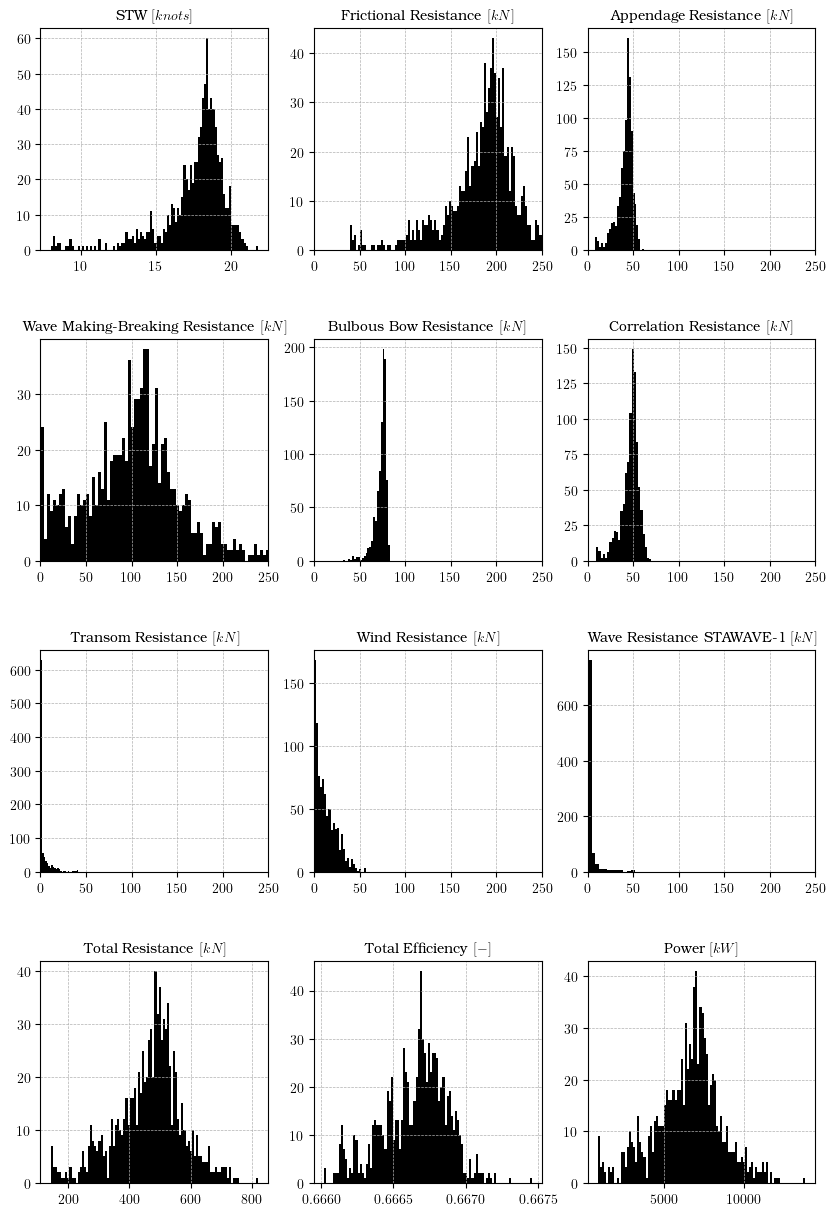

In [421]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_act_yr
R_f = Rf_act_yr/1e3
R_app = R_app_act_yr/1e3
R_w = R_w_act_yr/1e3
R_b = R_b_act_yr/1e3
R_tr = R_tr_act_yr/1e3
R_a = R_a_act_yr/1e3
R_aa = R_aa_act_yr/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_act_yr/1e3
R_tot = R_tot_act_yr
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_act_yr
P_b = P_b_act_yr
FOC = FOC_act_yr



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=100,color='black')
axes[0, 0].set_title(r'STW $[knots]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=100,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 1].set_xlim(0,250)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 2].set_xlim(0,250)

axes[1, 0].hist(R_w,bins=100,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 0].set_xlim(0,250)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 1].set_xlim(0,250)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 2].set_xlim(0,250)

axes[2, 1].hist(R_aa,bins=25,color='black')
axes[2, 1].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 1].set_xlim(0,250)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_awl,bins=25,color='black')
axes[2, 2].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 2].set_xlim(0,250)

axes[2, 0].hist(R_tr,bins=25,color='black')
axes[2, 0].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 0].set_xlim(0,250)

axes[3, 0].hist(R_tot,bins=100,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=100,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=100,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [422]:
def FOC_plot_yr(FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr):
    rmse_opt = [FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("FOC comparison for yearly data")
    plt.ylabel("FOC [T/h]")
    plt.xlabel("Period")
    plt.yscale('linear')
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'$FOC_{actual}$', r'$FOC_{ETR}$',
                        r'$FOC_{RFR}$', r'$FOC_{DTR}$'])

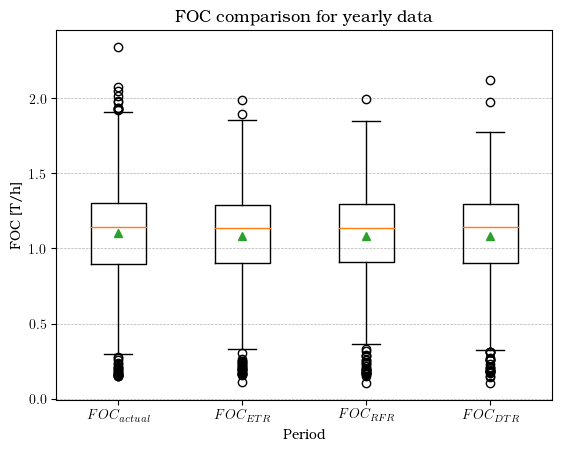

In [423]:
FOC_plot_yr(FOC_act_yr,FOC_pred_yr,FOC_pred_rf_yr,FOC_pred_dt_yr)
plt.show()

Polyfit Evaluations

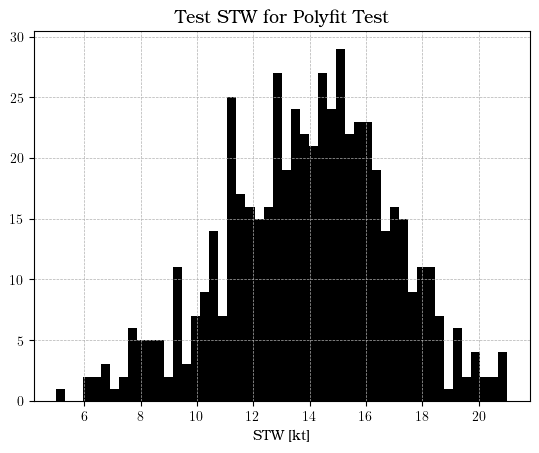

In [424]:
import random
from sklearn.preprocessing import PolynomialFeatures

# # Simulate model performance by inserting arbitrary STW in knots

# Skewed distribution of random numbers

# Set the seed for reproducibility
seed_value = 0
np.random.seed(seed_value)

# Parameters for the right-skewed normal distribution
mean = 16  # Mean of the distribution
std_dev = -2.5  # Standard deviation of the distribution
skewness_factor = .1  # Skewness factor to control the skewness

# Range of the random numbers you want to generate
minimum = 5
maximum = 21

# Generate random numbers with a standard normal distribution
n = 558  # Number of random numbers to generate
standard_normal_values = np.random.randn(n)

# Transform the standard normal distribution into a right-skewed distribution
right_skewed_values = mean + std_dev * np.exp(skewness_factor * standard_normal_values)

# Scale and shift the values to the desired range
scaled_values = (right_skewed_values - np.min(right_skewed_values)) / (np.max(right_skewed_values) - np.min(right_skewed_values))
v_stw = minimum + scaled_values * (maximum - minimum)
v_stw = v_stw.reshape(-1,1)
plt.hist(v_stw,bins=50,color='black')
plt.title(r"Test STW for Polyfit Test", fontsize=13)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel('STW [kt]')
plt.show()
poly_stw = PolynomialFeatures(degree=4)
poly_stw3 = PolynomialFeatures(degree=3)
stw_poly = poly_stw.fit_transform(v_stw)
stw_poly3 = poly_stw3.fit_transform(v_stw)

In [425]:
# This model defines the performance of the generated polyfit line from the model

def evaluate_FOC_poly(model,FOC_poly_act,FOC_poly_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_ply = r2_score(FOC_poly_act,FOC_poly_pred)
    expVar_ply = explained_variance_score(FOC_poly_act,FOC_poly_pred)
    MAE_ply = mean_absolute_error(FOC_poly_act,FOC_poly_pred)
    RMSE_ply = np.sqrt(mean_squared_error(FOC_poly_act,FOC_poly_pred))
    MAD_ply = median_absolute_error(FOC_poly_act,FOC_poly_pred)
    MAPE_ply = mean_absolute_percentage_error(FOC_poly_act,FOC_poly_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_ply:0.4f}")
    print(f"Explained Variance {expVar_ply:0.4f}")
    print(f"MAE {MAE_ply:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_ply:0.4f} T/h")
    print(f"MAD {MAD_ply:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_ply*100:0.4f} %")

On year datasets

In [426]:
FOC_act_ply_yr = poly_act_yr.predict(stw_poly)
# Test on different tree based model
FOC_etr_ply_yr = poly_etr_yr.predict(stw_poly)
FOC_rfr_ply_yr = poly_rfr_yr.predict(stw_poly)
FOC_dtr_ply_yr = poly_dtr_yr.predict(stw_poly)
# Evaluate performance 
evaluate_FOC_poly(model_etr_hpov,FOC_act_ply_yr,FOC_etr_ply_yr)
evaluate_FOC_poly(model_rfr_hpov,FOC_act_ply_yr,FOC_rfr_ply_yr)
evaluate_FOC_poly(model_dtr_hpov,FOC_act_ply_yr,FOC_dtr_ply_yr)


Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0010 T/h
RMSE FOC 0.0022 T/h
MAD 0.0006 T/h
MAPE FOC 0.3436 %
Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0009 T/h
RMSE FOC 0.0023 T/h
MAD 0.0005 T/h
MAPE FOC 0.3448 %
Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0013 T/h
RMSE FOC 0.0017 T/h
MAD 0.0013 T/h
MAPE FOC 0.4234 %


On Winter datasets

In [427]:
FOC_act_ply_w = poly_act_w.predict(stw_poly)
# Test on different tree based model
FOC_etr_ply_w = poly_etr_w.predict(stw_poly)
FOC_rfr_ply_w = poly_rfr_w.predict(stw_poly)
FOC_dtr_ply_w = poly_dtr_w.predict(stw_poly)
# Evaluate performance 
evaluate_FOC_poly(model_etr_hpov,FOC_act_ply_w,FOC_etr_ply_w)
evaluate_FOC_poly(model_rfr_hpov,FOC_act_ply_w,FOC_rfr_ply_w)
evaluate_FOC_poly(model_dtr_hpov,FOC_act_ply_w,FOC_dtr_ply_w)


Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.9998
Explained Variance 0.9998
MAE 0.0043 T/h
RMSE FOC 0.0048 T/h
MAD 0.0046 T/h
MAPE FOC 0.9974 %
Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.9998
Explained Variance 0.9998
MAE 0.0045 T/h
RMSE FOC 0.0051 T/h
MAD 0.0049 T/h
MAPE FOC 1.0388 %
Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.9998
Explained Variance 0.9998
MAE 0.0047 T/h
RMSE FOC 0.0053 T/h
MAD 0.0050 T/h
MAPE FOC 1.1274 %


On Summer Datasets

In [428]:
# # Special case for summer, since best model is power 3 
# FOC_act_ply_s = poly_act_s.predict(stw_poly3)
# otherwise use brute force
FOC_act_ply_s = poly_act_s.predict(stw_poly)
# Test on different tree based model
FOC_etr_ply_s = poly_etr_s.predict(stw_poly)
FOC_rfr_ply_s = poly_rfr_s.predict(stw_poly)
FOC_dtr_ply_s = poly_dtr_s.predict(stw_poly)
# Evaluate performance 
evaluate_FOC_poly(model_etr_hpov,FOC_act_ply_s,FOC_etr_ply_s)
evaluate_FOC_poly(model_rfr_hpov,FOC_act_ply_s,FOC_rfr_ply_s)
evaluate_FOC_poly(model_dtr_hpov,FOC_act_ply_s,FOC_dtr_ply_s)


Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.9995
Explained Variance 0.9996
MAE 0.0062 T/h
RMSE FOC 0.0073 T/h
MAD 0.0066 T/h
MAPE FOC 1.4376 %
Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.9995
Explained Variance 0.9995
MAE 0.0062 T/h
RMSE FOC 0.0078 T/h
MAD 0.0064 T/h
MAPE FOC 1.4550 %
Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.9997
Explained Variance 0.9997
MAE 0.0051 T/h
RMSE FOC 0.0060 T/h
MAD 0.0051 T/h
MAPE FOC 1.3207 %
